<a href="https://colab.research.google.com/github/My1stK8s/skillfactoryds/blob/master/Diplom/diplom_nba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install tabnet
!pip install pytorch_tabnet
!pip install catboost
!pip install xgboost

     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 9.2 MB/s 
     |████████████████████████████████| 210 kB 67.1 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 112 kB 38.5 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 149 kB 58.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5abcc152e29c8ba592bfb202a40c8c3a8bf752404acd0f306f55480d92e750e8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [ ]:
!nvidia-smi


/bin/bash: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from pytorch_tabnet.tab_model import TabNetClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import  XGBClassifier
import torch
import optuna
from optuna import Trial, visualization
from pytorch_tabnet.tab_model import TabNetClassifier
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix,roc_auc_score,confusion_matrix,accuracy_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import requests
import pandas as pd
import os
from tqdm import tqdm
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from xgboost import XGBClassifier

In [ ]:

games_header = {
    'user-agent': 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/57.0.2987.133 Safari/537.36',
    'Dnt': '1',
    'Accept-Encoding': 'gzip, deflate, sdch',
    'Accept-Language': 'en',
    'origin': 'http://stats.nba.com',
    'Referer': 'https://github.com'
}

data_headers = {
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_2) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.4 Safari/605.1.15',
    'Accept-Language': 'en-us',
    'Referer': 'https://stats.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2019-20&SeasonType=Regular%20Season',
    'Connection': 'keep-alive',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'
}

todays_games_url = 'https://data.nba.com/data/10s/v2015/json/mobile_teams/nba/2021/scores/00_todays_scores.json'


data_url = 'https://stats.nba.com/stats/leaguedashteamstats?' \
           'Conference=&DateFrom=&DateTo=&Division=&GameScope=&' \
           'GameSegment=&LastNGames=0&LeagueID=00&Location=&' \
           'MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&' \
           'PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&' \
           'PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&' \
           'Season=2021-22&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&' \
           'StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='



def get_json_data(url):
    raw_data = requests.get(url, headers=data_headers)
    json = raw_data.json()
    return json.get('resultSets')


def get_todays_games_json(url):
    raw_data = requests.get(url, headers=games_header)
    json = raw_data.json()
    return json.get('gs').get('g')


def to_data_frame(data):
    data_list = data[0]
    return pd.DataFrame(data=data_list.get('rowSet'), columns=data_list.get('headers'))


def create_todays_games(input_list):
    games = []
    for game in input_list:
        home = game.get('h')
        away = game.get('v')
        home_team = home.get('tc') + ' ' + home.get('tn')
        away_team = away.get('tc') + ' ' + away.get('tn')
        games.append([home_team, away_team])
    return games

def createTodaysGames(games, df):
    match_data = []
    for game in games:
        home_team = game[0]
        away_team = game[1]
        home_team_series = df.iloc[team_index_current.get(home_team)]
        away_team_series = df.iloc[team_index_current.get(away_team)]
        stats = home_team_series.append(away_team_series)
        match_data.append(stats)

    games_data_frame = pd.concat(match_data, ignore_index=True, axis=1)
    games_data_frame = games_data_frame.T

    frame_ml = games_data_frame.drop(columns=['TEAM_ID', 'CFID', 'CFPARAMS', 'TEAM_NAME'])
    frame_ml['Date'] = "02-16-2021-22"
    frame_ml = preproc(frame_ml)
    frame_ml.drop(columns=['Date'],inplace=True)
    
    data = frame_ml.values
    data = data.astype(float)

    return data,frame_ml,games_data_frame

# Таблица метрик для сравнения результатов каждой модели
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
summary = pd.DataFrame(index = metrics)
def metrics(summary,col,y_test,y_pred):
    values = [accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred), f1_score(y_test,y_pred),]
    summary[col] = values
    return summary

# Confusion matrix
def conf_mat(y_test, y_pred):
    P = np.sum(y_test==1)
    N = np.sum(y_test==0)
    print('Positive: {0}, Negative: {1}'.format(P,N))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(tp, fp) 
    print(fn, tn)

# Date preproc
def preproc(X):
    data= X['Date'].str.split('-',expand=True)
    data.columns=['month','day','year','end_year']
    X = pd.concat([X,data],axis = 1)
    X['month'] = X['month'].astype(int)
    X['day'] = X['day'].astype(int)
    X['year'] = X['year'].astype(int)
    X['end_year'] = X['end_year'].astype(int)
    return X

In [ ]:
# На  протяжении  всех  сезонов  команды меняли названия заполним их что б  правильно  получить данные !
team_codes = {
    'Atlanta': 'Atlanta Hawks',
    'NewJersey': 'New Jersey Nets',
    'Boston': 'Boston Celtics',
    'Brooklyn': 'Brooklyn Nets',
    'Charlotte': 'Charlotte Bobcats',
    'Chicago': 'Chicago Bulls',
    'Cleveland': 'Cleveland Cavaliers',
    'Dallas': 'Dallas Mavericks',
    'Denver': 'Denver Nuggets',
    'Detroit': 'Detroit Pistons',
    'GoldenState': 'Golden State Warriors',
    'Houston': 'Houston Rockets',
    'Indiana': 'Indiana Pacers',
    'LAClippers': 'Los Angeles Clippers',
    'LALakers': 'Los Angeles Lakers',
    'Memphis': 'Memphis Grizzlies',
    'Miami': 'Miami Heat',
    'Milwaukee': 'Milwaukee Bucks',
    'Minnesota': 'Minnesota Timberwolves',
    'NewOrleans': 'New Orleans Pelicans',
    'NewYork': 'New York Knicks',
    'OklahomaCity': 'Oklahoma City Thunder',
    'Seattle': 'Seattle SuperSonics',
    'Orlando': 'Orlando Magic',
    'Philadelphia': 'Philadelphia 76ers',
    'Phoenix': 'Phoenix Suns',
    'Portland': 'Portland Trail Blazers',
    'Sacramento': 'Sacramento Kings',
    'SanAntonio': 'San Antonio Spurs',
    'Toronto': 'Toronto Raptors',
    'Utah': 'Utah Jazz',
    'Washington': 'Washington Wizards',
}

team_index_07 = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Charlotte Bobcats': 2,
    'Chicago Bulls': 3,
    'Cleveland Cavaliers': 4,
    'Dallas Mavericks': 5,
    'Denver Nuggets': 6,
    'Detroit Pistons': 7,
    'Golden State Warriors': 8,
    'Houston Rockets': 9,
    'Indiana Pacers': 10,
    'Los Angeles Clippers': 11,
    'Los Angeles Lakers': 12,
    'Memphis Grizzlies': 13,
    'Miami Heat': 14,
    'Milwaukee Bucks': 15,
    'Minnesota Timberwolves': 16,
    'New Jersey Nets': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Orlando Magic': 20,
    'Philadelphia 76ers': 21,
    'Phoenix Suns': 22,
    'Portland Trail Blazers': 23,
    'Sacramento Kings': 24,
    'San Antonio Spurs': 25,
    'Seattle SuperSonics': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

team_index_08 = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Charlotte Bobcats': 2,
    'Chicago Bulls': 3,
    'Cleveland Cavaliers': 4,
    'Dallas Mavericks': 5,
    'Denver Nuggets': 6,
    'Detroit Pistons': 7,
    'Golden State Warriors': 8,
    'Houston Rockets': 9,
    'Indiana Pacers': 10,
    'Los Angeles Clippers': 11,
    'Los Angeles Lakers': 12,
    'Memphis Grizzlies': 13,
    'Miami Heat': 14,
    'Milwaukee Bucks': 15,
    'Minnesota Timberwolves': 16,
    'New Jersey Nets': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Oklahoma City Thunder': 20,
    'Orlando Magic': 21,
    'Philadelphia 76ers': 22,
    'Phoenix Suns': 23,
    'Portland Trail Blazers': 24,
    'Sacramento Kings': 25,
    'San Antonio Spurs': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

team_index_12 = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Brooklyn Nets': 2,
    'Charlotte Bobcats': 3,
    'Chicago Bulls': 4,
    'Cleveland Cavaliers': 5,
    'Dallas Mavericks': 6,
    'Denver Nuggets': 7,
    'Detroit Pistons': 8,
    'Golden State Warriors': 9,
    'Houston Rockets': 10,
    'Indiana Pacers': 11,
    'Los Angeles Clippers': 12,
    'Los Angeles Lakers': 13,
    'Memphis Grizzlies': 14,
    'Miami Heat': 15,
    'Milwaukee Bucks': 16,
    'Minnesota Timberwolves': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Oklahoma City Thunder': 20,
    'Orlando Magic': 21,
    'Philadelphia 76ers': 22,
    'Phoenix Suns': 23,
    'Portland Trail Blazers': 24,
    'Sacramento Kings': 25,
    'San Antonio Spurs': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

team_index_13 = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Brooklyn Nets': 2,
    'Charlotte Bobcats': 3,
    'Chicago Bulls': 4,
    'Cleveland Cavaliers': 5,
    'Dallas Mavericks': 6,
    'Denver Nuggets': 7,
    'Detroit Pistons': 8,
    'Golden State Warriors': 9,
    'Houston Rockets': 10,
    'Indiana Pacers': 11,
    'Los Angeles Clippers': 12,
    'Los Angeles Lakers': 13,
    'Memphis Grizzlies': 14,
    'Miami Heat': 15,
    'Milwaukee Bucks': 16,
    'Minnesota Timberwolves': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Oklahoma City Thunder': 20,
    'Orlando Magic': 21,
    'Philadelphia 76ers': 22,
    'Phoenix Suns': 23,
    'Portland Trail Blazers': 24,
    'Sacramento Kings': 25,
    'San Antonio Spurs': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

team_index_14 = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Brooklyn Nets': 2,
    'Charlotte Bobcats': 3,
    'Chicago Bulls': 4,
    'Cleveland Cavaliers': 5,
    'Dallas Mavericks': 6,
    'Denver Nuggets': 7,
    'Detroit Pistons': 8,
    'Golden State Warriors': 9,
    'Houston Rockets': 10,
    'Indiana Pacers': 11,
    'Los Angeles Clippers': 12,
    'Los Angeles Lakers': 13,
    'Memphis Grizzlies': 14,
    'Miami Heat': 15,
    'Milwaukee Bucks': 16,
    'Minnesota Timberwolves': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Oklahoma City Thunder': 20,
    'Orlando Magic': 21,
    'Philadelphia 76ers': 22,
    'Phoenix Suns': 23,
    'Portland Trail Blazers': 24,
    'Sacramento Kings': 25,
    'San Antonio Spurs': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

team_index_current = {
    'Atlanta Hawks': 0,
    'Boston Celtics': 1,
    'Brooklyn Nets': 2,
    'Charlotte Hornets': 3,
    'Chicago Bulls': 4,
    'Cleveland Cavaliers': 5,
    'Dallas Mavericks': 6,
    'Denver Nuggets': 7,
    'Detroit Pistons': 8,
    'Golden State Warriors': 9,
    'Houston Rockets': 10,
    'Indiana Pacers': 11,
    'Los Angeles Clippers': 12,
    'LA Clippers': 12,
    'Los Angeles Lakers': 13,
    'Memphis Grizzlies': 14,
    'Miami Heat': 15,
    'Milwaukee Bucks': 16,
    'Minnesota Timberwolves': 17,
    'New Orleans Pelicans': 18,
    'New York Knicks': 19,
    'Oklahoma City Thunder': 20,
    'Orlando Magic': 21,
    'Philadelphia 76ers': 22,
    'Phoenix Suns': 23,
    'Portland Trail Blazers': 24,
    'Sacramento Kings': 25,
    'San Antonio Spurs': 26,
    'Toronto Raptors': 27,
    'Utah Jazz': 28,
    'Washington Wizards': 29
}

In [ ]:
#Парсинг статистики  всех  команд  за  все  сезоны

url = 'https://stats.nba.com/stats/' \
      'leaguedashteamstats?Conference=&' \
      'DateFrom=10%2F29%2F{2}&DateTo={0}%2F{1}%2F{3}' \
      '&Division=&GameScope=&GameSegment=&LastNGames=0&' \
      'LeagueID=00&Location=&MeasureType=Base&Month=0&' \
      'OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&' \
      'PerMode=PerGame&Period=0&PlayerExperience=&' \
      'PlayerPosition=&PlusMinus=N&Rank=N&' \
      'Season={4}' \
      '&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&' \
      'StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='

year = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
season = ["2007-08", "2008-09","2009-10", "2010-11", "2011-12", "2012-13", "2013-14", "2014-15", "2015-16", "2016-17",
          "2017-18", "2018-19","2019-20", "2020-21", "2021-22"]
month = [ 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]
days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

begin_year_pointer = year[0]
end_year_pointer = year[0]
count = 0
year_count = 0

for season1 in tqdm(season):
    for month1 in tqdm(month):
        if month1 == 1:
            count += 1
            end_year_pointer = year[count]

        for day1 in tqdm(days):
            try:
                general_data = settings.get_json_data(
                    url.format(month1, day1, begin_year_pointer, end_year_pointer, season1))
                general_df = settings.to_data_frame(general_data)
                general_df['Date'] = str(month1) + '-' + str(day1) + '-' + season1

                directory2 = os.fsdecode('./data')
                name = directory2 + '/' + str(month1) + '-' + str(day1) + '-' + season1 + '.xlsx'
                general_df.to_excel(name)
            except:
                continue
    year_count += 1
    begin_year_pointer = year[count]



In [ ]:
# cкачаем  ручками  результаты  всех  сезонов  NBA - https://www.sportsbookreviewsonline.com/scoresoddsarchives/nba/nbaoddsarchives.htm
# обработаем  их  ,уберем лишнее, и соединим со  статистикой для  обучения с  подкреплением 
directory = os.fsdecode('../preprocessing/data/odds-data/filthy-odds-data')

for file in tqdm(os.listdir(directory)):
    filename = os.fsdecode(file)
    year = filename[9:-5]
    if filename.endswith('.xlsx'):
        df = pd.read_excel(directory + '/' + filename)
        x = pd.DataFrame(columns=['Date', 'Home', 'Away', 'OU', 'Spread', 'ML_Home', 'ML_Away', 'Points', 'Win_Margin'])
        count = 2
        date = ''
        home = ''
        away = ''
        ou = ''
        spread = ''
        ml_home = ''
        ml_away = ''
        points = ''
        margin = ''
        for row in df.itertuples():
            if count % 2 == 0:
                if len(str(row[1])) == 3:
                    date = str(year + '-' + '0' + str(row[1]))
                else:
                    date = str(year + '-' + str(row[1]))
                away = team_codes.get(str(row[4]))
                if row[10] == 'pk':
                    ou = 0
                else:
                    ou = row[10]
                points = row[9]
                ml_away = str(row[12])
                count += 1
            else:
                home = team_codes.get(str(row[4]))
                if row[10] == 'pk':
                    spread = 0
                else:
                    spread = row[10]
                if spread > 50:
                    temp = spread
                    spread = ou
                    ou = temp
                ml_home = str(row[12])
                margin = row[9] - points
                points += row[9]
                temp = {
                    'Date': date,
                    'Home': home,
                    'Away': away,
                    'OU': ou,
                    'Spread': spread,
                    'ML_Home': ml_home,
                    'ML_Away': ml_away,
                    'Points': points,
                    'Win_Margin': margin
                }
                x = x.append(temp, ignore_index=True)
                count += 1
                date = ''
                home = ''
                away = ''
                ou = ''
                spread = ''
                ml_home = ''
                ml_away = ''
                points = ''
                margin = ''
        directory2 = os.fsdecode('../preprocessing/data/odds-data/clean-odds-data')
        name = directory2 + '/' + year + '.xlsx'
        x.to_excel(name)


In [ ]:
# Создаем дата сет - произведем конкатенацию  команд  с их  статистикой  и их  результатами 
season_array = ["2007-08", "2008-09", "2009-10", "2010-11", "2011-12", "2012-13", "2013-14", "2014-15", "2015-16",
                "2016-17", "2017-18", "2018-19", "2019-20", "2020-21","2021-22"]

            odds_directory = os.fsdecode('Odds-Data/Odds-Data-Clean')
df = pd.DataFrame
scores = []
win_margin = []
OU = []
OU_Cover = []
games = []
for season in tqdm(season_array):
    file = pd.read_excel(odds_directory + '/' + '{}.xlsx'.format(season))

    team_data_directory = os.fsdecode('../../Team-Data/{}'.format(season))

    for row in file.itertuples():
        home_team = row[3]
        away_team = row[4]

        date = row[2]
        date_array = date.split('-')
        year = date_array[0] + '-' + date_array[1]
        month = date_array[2][:2]
        day = date_array[2][2:]

        if month[0] == '0':
            month = month[1:]
        if day[0] == '0':
            day = day[1:]

        team_data_file = month + '-' + day + '-' + year + '.xlsx'

        data_frame = pd.read_excel(team_data_directory + '/' + team_data_file)

        if len(data_frame.index) == 30:
            scores.append(row[9])
            OU.append(row[5])
            if row[10] > 0:
                win_margin.append(1)
            else:
                win_margin.append(0)
            print(row[5])

            if row[9] < row[5]:
                OU_Cover.append(0)
            elif row[9] > row[5]:
                OU_Cover.append(1)
            elif row[9] == row[5]:
                OU_Cover.append(2)
            if season == '2007-08':
                home_team_series = data_frame.iloc[team_index_07.get(home_team)]
                away_team_series = data_frame.iloc[team_index_07.get(away_team)]
            elif season == '2008-09' or season == "2009-10" or season == "2010-11" or season == "2011-12":
                home_team_series = data_frame.iloc[team_index_08.get(home_team)]
                away_team_series = data_frame.iloc[team_index_08.get(away_team)]
            elif season == "2012-13":
                home_team_series = data_frame.iloc[team_index_12.get(home_team)]
                away_team_series = data_frame.iloc[team_index_12.get(away_team)]
            elif season == '2013-14':
                home_team_series = data_frame.iloc[team_index_13.get(home_team)]
                away_team_series = data_frame.iloc[team_index_13.get(away_team)]
            else:
                home_team_series = data_frame.iloc[team_index_14.get(home_team)]
                away_team_series = data_frame.iloc[team_index_14.get(away_team)]

            game = home_team_series.append(away_team_series)
            games.append(game)
season = pd.concat(games, ignore_index=True, axis=1)
season = season.T

frame = season.drop(columns=['TEAM_ID', 'CFID', 'CFPARAMS', 'Unnamed: 0'])
frame['Score'] = np.asarray(scores)
frame['Home-Team-Win'] = np.asarray(win_margin)
frame['OU'] = np.asarray(OU)
frame['OU-Cover'] = np.asarray(OU_Cover)
frame.to_csv('Data/allseasons2007-22.csv')


IndentationError: unexpected indent (Temp/ipykernel_13112/2739932872.py, line 5)

In [ ]:
# pip install pytorch_tabnet
torch.cuda.is_available()

False

In [ ]:
# Загружаем данные
df = pd.read_csv('allseasons2007-22.csv')
df.drop(['Score',  'Unnamed: 0', 'TEAM_NAME', 'TEAM_NAME.1', 'Date.1', 'OU-Cover', 'OU','TEAM_ID','TEAM_ID.1'],
          axis=1, inplace=True)
df.drop_duplicates(keep=False)

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,AST_RANK.1,TOV_RANK.1,STL_RANK.1,BLK_RANK.1,BLKA_RANK.1,PF_RANK.1,PFD_RANK.1,PTS_RANK.1,PLUS_MINUS_RANK.1,Home-Team-Win
0,1,1,0,1.000,48.0,37.0,76.0,0.487,6.0,16.0,...,26,20,23,10,24,30,15,26,24,1
1,2,1,1,0.500,48.0,31.5,75.0,0.420,10.0,20.0,...,16,6,12,10,3,2,21,9,3,0
2,2,2,0,1.000,50.5,35.5,87.5,0.406,10.0,22.0,...,24,23,23,7,27,2,30,30,19,1
3,2,1,1,0.500,50.5,29.0,75.0,0.387,7.5,22.0,...,3,3,9,24,22,7,22,4,1,0
4,1,1,0,1.000,48.0,36.0,79.0,0.456,4.0,15.0,...,24,7,25,3,3,10,18,24,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18274,42,16,26,0.381,48.2,42.7,93.0,0.459,11.0,31.0,...,23,1,8,5,11,13,18,20,11,0
18275,43,24,19,0.558,48.2,38.8,85.5,0.454,11.9,36.1,...,10,10,1,1,30,12,15,7,6,1
18276,41,22,19,0.537,48.2,40.6,86.9,0.467,12.7,36.5,...,27,25,9,21,20,29,3,28,30,1
18277,42,20,22,0.476,48.4,40.5,91.7,0.442,14.3,41.5,...,6,21,21,7,21,27,13,2,8,1


In [ ]:
# Загружаем данные
df = pd.read_csv('allseasons2007-22.csv')
df.drop(['Score',  'Unnamed: 0', 'TEAM_NAME', 'TEAM_NAME.1', 'Date.1', 'OU-Cover', 'OU','TEAM_ID','TEAM_ID.1'],
          axis=1, inplace=True)
df.drop_duplicates(keep=False)

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,AST_RANK.1,TOV_RANK.1,STL_RANK.1,BLK_RANK.1,BLKA_RANK.1,PF_RANK.1,PFD_RANK.1,PTS_RANK.1,PLUS_MINUS_RANK.1,Home-Team-Win
0,1,1,0,1.000,48.0,37.0,76.0,0.487,6.0,16.0,...,26,20,23,10,24,30,15,26,24,1
1,2,1,1,0.500,48.0,31.5,75.0,0.420,10.0,20.0,...,16,6,12,10,3,2,21,9,3,0
2,2,2,0,1.000,50.5,35.5,87.5,0.406,10.0,22.0,...,24,23,23,7,27,2,30,30,19,1
3,2,1,1,0.500,50.5,29.0,75.0,0.387,7.5,22.0,...,3,3,9,24,22,7,22,4,1,0
4,1,1,0,1.000,48.0,36.0,79.0,0.456,4.0,15.0,...,24,7,25,3,3,10,18,24,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18274,42,16,26,0.381,48.2,42.7,93.0,0.459,11.0,31.0,...,23,1,8,5,11,13,18,20,11,0
18275,43,24,19,0.558,48.2,38.8,85.5,0.454,11.9,36.1,...,10,10,1,1,30,12,15,7,6,1
18276,41,22,19,0.537,48.2,40.6,86.9,0.467,12.7,36.5,...,27,25,9,21,20,29,3,28,30,1
18277,42,20,22,0.476,48.4,40.5,91.7,0.442,14.3,41.5,...,6,21,21,7,21,27,13,2,8,1


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using {}".format(DEVICE))

Using cpu


In [ ]:
#разобьем данные о Дате на  колонки и добавим  в датасет 
dd = preproc(df) 


In [ ]:
dd

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,BLKA_RANK.1,PF_RANK.1,PFD_RANK.1,PTS_RANK.1,PLUS_MINUS_RANK.1,Home-Team-Win,month,day,year,end_year
0,1,1,0,1.000,48.0,37.0,76.0,0.487,6.0,16.0,...,24,30,15,26,24,1,11,2,2007,8
1,2,1,1,0.500,48.0,31.5,75.0,0.420,10.0,20.0,...,3,2,21,9,3,0,11,2,2007,8
2,2,2,0,1.000,50.5,35.5,87.5,0.406,10.0,22.0,...,27,2,30,30,19,1,11,2,2007,8
3,2,1,1,0.500,50.5,29.0,75.0,0.387,7.5,22.0,...,22,7,22,4,1,0,11,2,2007,8
4,1,1,0,1.000,48.0,36.0,79.0,0.456,4.0,15.0,...,3,10,18,24,11,1,11,2,2007,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18274,42,16,26,0.381,48.2,42.7,93.0,0.459,11.0,31.0,...,11,13,18,20,11,0,1,23,2021,22
18275,43,24,19,0.558,48.2,38.8,85.5,0.454,11.9,36.1,...,30,12,15,7,6,1,1,23,2021,22
18276,41,22,19,0.537,48.2,40.6,86.9,0.467,12.7,36.5,...,20,29,3,28,30,1,1,23,2021,22
18277,42,20,22,0.476,48.4,40.5,91.7,0.442,14.3,41.5,...,21,27,13,2,8,1,1,23,2021,22


In [ ]:
dd.drop(columns=["Date"],inplace=True)

In [ ]:
dd

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,BLKA_RANK.1,PF_RANK.1,PFD_RANK.1,PTS_RANK.1,PLUS_MINUS_RANK.1,Home-Team-Win,month,day,year,end_year
0,1,1,0,1.000,48.0,37.0,76.0,0.487,6.0,16.0,...,24,30,15,26,24,1,11,2,2007,8
1,2,1,1,0.500,48.0,31.5,75.0,0.420,10.0,20.0,...,3,2,21,9,3,0,11,2,2007,8
2,2,2,0,1.000,50.5,35.5,87.5,0.406,10.0,22.0,...,27,2,30,30,19,1,11,2,2007,8
3,2,1,1,0.500,50.5,29.0,75.0,0.387,7.5,22.0,...,22,7,22,4,1,0,11,2,2007,8
4,1,1,0,1.000,48.0,36.0,79.0,0.456,4.0,15.0,...,3,10,18,24,11,1,11,2,2007,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18274,42,16,26,0.381,48.2,42.7,93.0,0.459,11.0,31.0,...,11,13,18,20,11,0,1,23,2021,22
18275,43,24,19,0.558,48.2,38.8,85.5,0.454,11.9,36.1,...,30,12,15,7,6,1,1,23,2021,22
18276,41,22,19,0.537,48.2,40.6,86.9,0.467,12.7,36.5,...,20,29,3,28,30,1,1,23,2021,22
18277,42,20,22,0.476,48.4,40.5,91.7,0.442,14.3,41.5,...,21,27,13,2,8,1,1,23,2021,22


In [ ]:
# подготовим данные  для  обучени  поделим для  эксперемента на разные  части 

In [ ]:
train3000 = dd[15000:18000]
X3000 = train3000.drop(['Home-Team-Win'], axis=1).values
y3000 = train3000['Home-Team-Win'].values

In [ ]:
# test  all 279 next match
test279 = dd[18000:18279]
X279 = test279.drop(['Home-Team-Win'],axis=1).values
y279 =  test279['Home-Team-Win'].values


In [ ]:
train18000=dd[:18000]
X18000 = train18000.drop(['Home-Team-Win'], axis=1).values
y18000 = train18000['Home-Team-Win'].values

In [ ]:
X18000.shape,y18000.shape,X3000.shape,y3000.shape,X279.shape,y279.shape

((18000, 108), (18000,), (3000, 108), (3000,), (279, 108), (279,))

In [ ]:
# модель рандомного  предсказания 

In [ ]:
X279['randpred1'] = np.random.choice([0,1], X279.shape[0])
X279['randpred2'] = np.random.choice([0,1], X279.shape[0])
X279['randpred3'] = np.random.choice([0,1], X279.shape[0])
X279['randpredmean']=X279[['randpred1','randpred2','randpred3']].mean(axis=1)
def transform(x):
    if  x['randpredmean'] > 0.5:
        x['randpredmean'] = 1
    elif x['randpredmean'] < 0.5:
        x['randpredmean'] = 0
    return x
X279 = X279.apply(transform, axis=1)
X279['randpredmean'].value_counts()
accuracy = accuracy_score(y279,X279['randpredmean'])
accuracy

In [ ]:
# Построим нашу нейросеть на  табличных  данных "Tabnet"

In [ ]:
# наивная модель последние  2 сезона 

In [ ]:
clfn3000 = TabNetClassifier(verbose=0)
clfn3000.fit(X_train=X3000, y_train=y3000)  

No early stopping will be performed, last training weights will be used.


In [ ]:
# метрики предсказания для 3000 игр
y_pred3000 = clfn3000.predict(X3000)
metrics(summary,'clfn3000',y3000,y_pred3000),conf_mat(y3000, y_pred3000)

Positive: 1659, Negative: 1341
966 359
693 982


(           clfn3000
 accuracy   0.649333
 precision  0.729057
 recall     0.582278
 f1_score   0.647453, None)

In [ ]:
# тест 279 последних  игр
y_pred279 = clfn3000.predict(X279)
metrics(summary,'clfn3000-279',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 153, Negative: 126
84 38
69 88


(           clfn3000  clfn3000-279
 accuracy   0.649333      0.616487
 precision  0.729057      0.688525
 recall     0.582278      0.549020
 f1_score   0.647453      0.610909, None)

In [ ]:
# наивная модель все сезоны 

In [ ]:
clfn18000 = TabNetClassifier(verbose=0)
clfn18000.fit(X_train=X18000, y_train=y18000)  

No early stopping will be performed, last training weights will be used.


In [ ]:
# тест 18000 последних  игр
y_pred18000 = clfn18000.predict(X18000)
metrics(summary,'clfn18000',y18000,y_pred18000),conf_mat(y18000, y_pred18000)

Positive: 10594, Negative: 7406
8706 3031
1888 4375


(           clfn3000  clfn3000-279  clfn18000
 accuracy   0.649333      0.616487   0.726722
 precision  0.729057      0.688525   0.741757
 recall     0.582278      0.549020   0.821786
 f1_score   0.647453      0.610909   0.779723, None)

In [ ]:
# тест 18000 последних  игр
y_pred279 = clfn18000.predict(X279)
metrics(summary,'clfn18000-279',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 153, Negative: 126
107 57
46 69


(           clfn3000  clfn3000-279  clfn18000  clfn18000-279
 accuracy   0.649333      0.616487   0.726722       0.630824
 precision  0.729057      0.688525   0.741757       0.652439
 recall     0.582278      0.549020   0.821786       0.699346
 f1_score   0.647453      0.610909   0.779723       0.675079, None)

In [ ]:
#  так  как результаты  оказались  лучше  на всей   выборке  матчей будем  работать с ними !

In [ ]:
# поиск гиперпараметров Tabnet c проверкой  KFold
def Objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_d = trial.suggest_int("n_d", 4, 64, step=1)
    n_a = trial.suggest_int("n_a", 4, 64, step=1)
    n_steps = trial.suggest_int("n_steps", 2, 10, step=1)
    gamma = trial.suggest_float("gamma", 0.8, 2, step=0.1)
    n_shared = trial.suggest_int("n_shared", 1, 10, step=1)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    
    tabnet_params = dict(n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="max",
                                           # changing sheduler patience to be lower than early stopping patience 
                                           min_lr=2e-2,
                                           factor=0.5,
                                           ),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     device_name = DEVICE,
                     verbose=0,
                     ) #early stopping
    kfs = KFold(n_splits=10,random_state=42,shuffle=True)
    CV_score_array=[]
    for train_index, test_index in kfs.split(X18000,y18000):
        X_train, X_valid = X18000[train_index], X18000[test_index]
        y_train, y_valid = y18000[train_index], y18000[test_index]
        clf = TabNetClassifier(**tabnet_params)
        clf.fit(X_train=X_train, y_train=y_train,
                  eval_set=[(X_valid, y_valid)],
                  patience= 50,
                  max_epochs=trial.suggest_int('epochs', 250,300, step = 50),
                  batch_size=2048,
                  virtual_batch_size = 47 ,  
                  eval_metric=['accuracy'], 
                  num_workers=0,
                  weights=1,
                  drop_last=False)
        CV_score_array.append(clf.best_cost)
    avg = np.mean(CV_score_array)
    return avg

In [ ]:
study = optuna.create_study(direction="maximize", study_name='TabNet optimization')
study.optimize(Objective, timeout=6*60)


[I 2022-02-03 21:09:34,763] A new study created in memory with name: TabNet optimization



Early stopping occurred at epoch 99 with best_epoch = 49 and best_val_0_accuracy = 0.71833
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 130 with best_epoch = 80 and best_val_0_accuracy = 0.70444
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 142 with best_epoch = 92 and best_val_0_accuracy = 0.70278
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 141 with best_epoch = 91 and best_val_0_accuracy = 0.71111
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 21 and best_val_0_accuracy = 0.7
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 41 and best_val_0_accuracy = 0.715
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 217 with best_epoch = 167 and best_val_0_accuracy = 0.70333
Best weights from best epoch are automa

[I 2022-02-03 23:43:45,792] Trial 0 finished with value: 0.7056111111111111 and parameters: {'mask_type': 'entmax', 'n_d': 28, 'n_a': 64, 'n_steps': 4, 'gamma': 1.3, 'n_shared': 9, 'lambda_sparse': 1.6016541518387349e-06, 'epochs': 300}. Best is trial 0 with value: 0.7056111111111111.


In [ ]:
TabNet_params = study.best_params
print(TabNet_params)

{'mask_type': 'entmax', 'n_d': 28, 'n_a': 64, 'n_steps': 4, 'gamma': 1.3, 'n_shared': 9, 'lambda_sparse': 1.6016541518387349e-06, 'epochs': 300}


In [ ]:
# {'mask_type': 'entmax', 'n_d': 28, 'n_a': 64, 'n_steps': 4, 'gamma': 1.3, 'n_shared': 9, 'lambda_sparse': 1.6016541518387349e-06, 'epochs': 300}


In [ ]:
# обучение на  всем дата сете с результатами лучших гиперпараметров
final_params = dict(
    mask_type=TabNet_params['mask_type'],
    n_d=TabNet_params['n_d'],
    n_a=TabNet_params['n_a'],
    n_steps=TabNet_params['n_steps'],
    gamma=TabNet_params['gamma'],
    lambda_sparse=TabNet_params['lambda_sparse'],
    n_shared=TabNet_params['n_shared'],
    optimizer_fn=torch.optim.Adam)
clf = TabNetClassifier(**final_params,verbose=0)
clf.fit(X_train=X18000, y_train=y18000,
        max_epochs=TabNet_params['epochs'],
        patience= 50,
        batch_size=2048,
        virtual_batch_size=47)

No early stopping will be performed, last training weights will be used.


In [ ]:
# тест 18000  игр
y_pred18000 = clf.predict(X18000)
metrics(summary,'clf18000',y18000,y_pred18000),conf_mat(y18000, y_pred18000)

Positive: 10594, Negative: 7406
8877 2976
1717 4430


(           clfn3000  clfn3000-279  clfn18000  clfn18000-279  clf18000
 accuracy   0.649333      0.616487   0.726722       0.630824  0.739278
 precision  0.729057      0.688525   0.741757       0.652439  0.748924
 recall     0.582278      0.549020   0.821786       0.699346  0.837927
 f1_score   0.647453      0.610909   0.779723       0.675079  0.790930, None)

In [ ]:
# тест 279 последних  игр
y_pred279 = clf.predict(X279)
metrics(summary,'clf18000-279',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 153, Negative: 126
113 58
40 68


(           clfn3000  clfn3000-279  ...  clf18000  clf18000-279
 accuracy   0.649333      0.616487  ...  0.739278      0.648746
 precision  0.729057      0.688525  ...  0.748924      0.660819
 recall     0.582278      0.549020  ...  0.837927      0.738562
 f1_score   0.647453      0.610909  ...  0.790930      0.697531
 
 [4 rows x 6 columns], None)

In [ ]:
# результаты  улучшились сохраняем  модель 
saved_filename = clf.save_model('tabnet')
clf = TabNetClassifier()
clf.load_model('tabnet.zip')

Successfully saved model at /content/drive/MyDrive/data/tabnet.zip


In [ ]:
# Теперь  построим несколько ML моделей ("catboost",'Xgboost') и произведем  сразвнение 

In [ ]:
# наивная модель CatBoostClassifier
X_train,X_valid, y_train, y_valid = train_test_split(X18000, y18000, test_size=0.2)
cbmn = CatBoostClassifier()
cbmn.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

In [ ]:
# тест 18000  игр
y_pred18000 = cbmn.predict(X18000)
# y_pred18000 = np.rint(y_pred18000)
metrics(summary,'cbmn18000',y18000,y_pred18000),conf_mat(y18000, y_pred18000)

Positive: 10594, Negative: 7406
8678 2999
1916 4407


(           clfn3000  clfn3000-279  clfn18000  ...  clf18000  clf18000-279  cbmn18000
 accuracy   0.649333      0.616487   0.726722  ...  0.739278      0.648746   0.726944
 precision  0.729057      0.688525   0.741757  ...  0.748924      0.660819   0.743170
 recall     0.582278      0.549020   0.821786  ...  0.837927      0.738562   0.819143
 f1_score   0.647453      0.610909   0.779723  ...  0.790930      0.697531   0.779309
 
 [4 rows x 7 columns], None)

In [ ]:
# тест 279 последних  игр
y_pred279 = cbmn.predict(X279)

metrics(summary,'cbmn279',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 153, Negative: 126
107 53
46 73


(           clfn3000  clfn3000-279  clfn18000  ...  clf18000-279  cbmn18000   cbmn279
 accuracy   0.649333      0.616487   0.726722  ...      0.648746   0.726944  0.645161
 precision  0.729057      0.688525   0.741757  ...      0.660819   0.743170  0.668750
 recall     0.582278      0.549020   0.821786  ...      0.738562   0.819143  0.699346
 f1_score   0.647453      0.610909   0.779723  ...      0.697531   0.779309  0.683706
 
 [4 rows x 8 columns], None)

In [ ]:
# поиск гиперпараметров CatBoostClassifier c проверкой  KFold
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method",['Newton','Gradient']),
        "verbose": False}

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    '''cross-validation'''
    kf = KFold(n_splits=10,random_state=42,shuffle = True)
    CV_score_array =[]
    for train_index, test_index in kf.split(X18000,y18000):
        X_train, X_valid = X18000[train_index], X18000[test_index]
        y_train, y_valid = y18000[train_index], y18000[test_index]
        cbc = CatBoostClassifier(**param)
        cbc.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
        preds = cbc.predict(X_valid)
        # pred_labels = np.rint(preds)
        accuracy = accuracy_score(y_valid, preds)

        CV_score_array.append(accuracy)
    avg = np.mean(CV_score_array)

    return avg

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2022-02-04 00:58:12,794] A new study created in memory with name: no-name-6fd6df35-181f-407e-a878-4ae244fe07e0
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-02-04 01:00:32,696] Trial 0 finished with value: 0.7046111111111112 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.012498206365648218, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'leaf_estimation_method': 'Newton'}. Best is trial 0 with value: 0.7046111111111112.
[I 2022-02-04 01:05:07,145] Trial 1 finished with value: 0.7064444444444444 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.0981639976784009, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'leaf_estimation_method': 'Newton'}. Best is trial 1 with value: 0.7064444444444444.
[I 2022-02-04 01:15:06,732] Trial 2 finished with value: 0.706388888888889 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07956551343981516, 'dep

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 3
Best trial:
  Value: 0.7064444444444444
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.0981639976784009
    depth: 10
    boosting_type: Plain
    bootstrap_type: MVS
    leaf_estimation_method: Newton


In [ ]:
# обучение на  всем дата сете с результатами лучших гиперпараметров
X_train,X_valid, y_train, y_valid = train_test_split(X18000, y18000, test_size=0.2)
fcbm = CatBoostClassifier(**trial.params)
fcbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

In [ ]:
# сохраняем  модель 
fcbm.save_model("catboost")
catboost = CatBoostClassifier()

catboost.load_model("catboost")


In [ ]:
# тест 18000   игр
y_pred18000 = fcbm.predict(X18000)
metrics(summary,'fcbm18000',y18000,y_pred18000),conf_mat(y18000, y_pred18000)


In [ ]:
# тест 279 последних  игр
y_pred279 = fcbm.predict(X279)
metrics(summary,'fcbm279',y279,y_pred279),conf_mat(y279, y_pred279)

In [ ]:
# поиск гиперпараметров XGBClassifier с проверкой  cross validation
def objective(trial: Trial,X,y) -> float:
    param = {   'objective': 'multi:softprob',
                "n_estimators" : trial.suggest_int('n_estimators', 0, 100),
                "num_class" :  2,
                'max_depth': 2,
                'eta': 0.01,
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                # 'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
            }
    
    model = XGBClassifier(**param)
    
    return cross_val_score(model, X, y, cv=10).mean()

In [ ]:
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial,X18000,y18000),n_trials= 50)

In [ ]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

Best trial: score 0.7059444444444445,
params {'n_estimators': 31, 'reg_alpha': 0, 'reg_lambda': 3, 'min_child_weight': 2, 'gamma': 0, 'colsample_bytree': 0.99}


In [ ]:
# обучение на  всем дата сете с результатами лучших гиперпараметров
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X18000, y18000)
xgbc = xgb.XGBClassifier(**study.best_trial.params)
xgbc.fit(X18000, y18000)


XGBClassifier(colsample_bytree=0.99, min_child_weight=2, n_estimators=31,
              reg_lambda=3)

In [ ]:
# тест 18000 игр
y_pred18000 = xgbc.predict(X18000)
metrics(summary,'xgbc18000',y18000,y_pred18000),conf_mat(y18000, y_pred18000)


Positive: 10594, Negative: 7406
8532 3046
2062 4360


(           clf18000  clf18000-279  fcbm18000   fcbm279  xgbc18000   xgbc279
 accuracy   0.739278      0.648746   0.713778  0.645161   0.716222  0.655914
 precision  0.748924      0.660819   0.730985  0.660714   0.736915  0.666667
 recall     0.837927      0.738562   0.812819  0.725490   0.805362  0.745098
 f1_score   0.790930      0.697531   0.769733  0.691589   0.769619  0.703704,
 None)

In [ ]:
# тест 279 последних  игр
y_pred279 = xgbc.predict(X279)
metrics(summary,'xgbc279',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 153, Negative: 126
114 57
39 69


(           clf18000  clf18000-279  fcbm18000   fcbm279  xgbc18000   xgbc279
 accuracy   0.739278      0.648746   0.713778  0.645161   0.716222  0.655914
 precision  0.748924      0.660819   0.730985  0.660714   0.736915  0.666667
 recall     0.837927      0.738562   0.812819  0.725490   0.805362  0.745098
 f1_score   0.790930      0.697531   0.769733  0.691589   0.769619  0.703704,
 None)

In [ ]:
# Сохраняем  модель 
xgbc.save_model("/content/drive/MyDrive/data/xgbc.json")
xgbc = xgb.Booster()
xgbc.load_model('/content/drive/MyDrive/data/xgbc.json')


In [ ]:
# Загрузим наши  модели  и  взглянем на результаты метрик 

In [ ]:
clf = TabNetClassifier()
clf.load_model('/content/drive/MyDrive/data/tabnet.zip')

y_pred18000 = clf.predict(X18000)
metrics(summary,'TabnetTrain',y18000,y_pred18000),conf_mat(y18000, y_pred18000)
y_pred279 = clf.predict(X279)
metrics(summary,'TabnetTest',y279,y_pred279),conf_mat(y279, y_pred279)

Device used : cpu
Positive: 10594, Negative: 7406
8877 2976
1717 4430
Positive: 153, Negative: 126
113 58
40 68


(           TabnetTrain  TabnetTest
 accuracy      0.739278    0.648746
 precision     0.748924    0.660819
 recall        0.837927    0.738562
 f1_score      0.790930    0.697531, None)

In [ ]:
catboost = CatBoostClassifier()
catboost.load_model("/content/drive/MyDrive/data/catboost")

y_pred18000 = catboost.predict(X18000)
metrics(summary,'CatboostTrain',y18000,y_pred18000),conf_mat(y18000, y_pred18000)
y_pred279 = catboost.predict(X279)
metrics(summary,'CatboostTest',y279,y_pred279),conf_mat(y279, y_pred279)


Positive: 10594, Negative: 7406
8611 3169
1983 4237
Positive: 153, Negative: 126
111 57
42 69


(           TabnetTrain  TabnetTest  CatboostTrain  CatboostTest
 accuracy      0.739278    0.648746       0.713778      0.645161
 precision     0.748924    0.660819       0.730985      0.660714
 recall        0.837927    0.738562       0.812819      0.725490
 f1_score      0.790930    0.697531       0.769733      0.691589, None)

In [ ]:
xgb_ml = xgb.Booster()
xgb_ml.load_model('/content/drive/MyDrive/data/xgbc.json')
y_pred18000 = xgb_ml.predict(xgb.DMatrix(np.array(X18000)))
y_pred18000 = np.rint(y_pred18000)
metrics(summary,'XGBoostTrain',y18000,y_pred18000),conf_mat(y18000, y_pred18000)
y_pred279 = xgb_ml.predict(xgb.DMatrix(np.array(X279)))
y_pred279 = np.rint(y_pred279)
metrics(summary,'XGBoostTest',y279,y_pred279),conf_mat(y279, y_pred279)

Positive: 10594, Negative: 7406
8532 3046
2062 4360
Positive: 153, Negative: 126
114 57
39 69


(           TabnetTrain  TabnetTest  ...  XGBoostTrain  XGBoostTest
 accuracy      0.739278    0.648746  ...      0.716222     0.655914
 precision     0.748924    0.660819  ...      0.736915     0.666667
 recall        0.837927    0.738562  ...      0.805362     0.745098
 f1_score      0.790930    0.697531  ...      0.769619     0.703704
 
 [4 rows x 6 columns], None)

In [ ]:
# Результаты  примерно  одинаковые 

In [ ]:
summary

,TabnetTrain,TabnetTest,CatboostTrain,CatboostTest,XGBoostTrain,XGBoostTest
accuracy,0.739278,0.648746,0.713778,0.645161,0.716222,0.655914
precision,0.748924,0.660819,0.730985,0.660714,0.736915,0.666667
recall,0.837927,0.738562,0.812819,0.725490,0.805362,0.745098
f1_score,0.790930,0.697531,0.769733,0.691589,0.769619,0.703704


In [ ]:
# получим  данные  о предстоящем  матче   на  05.02.2022 и  подвидем  итоги 

In [ ]:
data = get_todays_games_json(todays_games_url)
games = create_todays_games(data)

data = get_json_data(data_url)
df = to_data_frame(data)
data, frame_ml ,games_data_frame = createTodaysGames(games, df)

C:\Users\my1st\AppData\Local\Temp/ipykernel_1272/2931232238.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_ml['Date'] = "02-16-2021-22"


In [ ]:
list(dd.columns)

['GP',
 'W',
 'L',
 'W_PCT',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'GP_RANK',
 'W_RANK',
 'L_RANK',
 'W_PCT_RANK',
 'MIN_RANK',
 'FGM_RANK',
 'FGA_RANK',
 'FG_PCT_RANK',
 'FG3M_RANK',
 'FG3A_RANK',
 'FG3_PCT_RANK',
 'FTM_RANK',
 'FTA_RANK',
 'FT_PCT_RANK',
 'OREB_RANK',
 'DREB_RANK',
 'REB_RANK',
 'AST_RANK',
 'TOV_RANK',
 'STL_RANK',
 'BLK_RANK',
 'BLKA_RANK',
 'PF_RANK',
 'PFD_RANK',
 'PTS_RANK',
 'PLUS_MINUS_RANK',
 'Date',
 'GP.1',
 'W.1',
 'L.1',
 'W_PCT.1',
 'MIN.1',
 'FGM.1',
 'FGA.1',
 'FG_PCT.1',
 'FG3M.1',
 'FG3A.1',
 'FG3_PCT.1',
 'FTM.1',
 'FTA.1',
 'FT_PCT.1',
 'OREB.1',
 'DREB.1',
 'REB.1',
 'AST.1',
 'TOV.1',
 'STL.1',
 'BLK.1',
 'BLKA.1',
 'PF.1',
 'PFD.1',
 'PTS.1',
 'PLUS_MINUS.1',
 'GP_RANK.1',
 'W_RANK.1',
 'L_RANK.1',
 'W_PCT_RANK.1',
 'MIN_RANK.1',
 'FGM_RANK.1',
 'FGA_RANK.1',
 'FG_PCT_RANK.1',
 'FG3M_RANK

In [ ]:
list(frame_ml.columns)

['GP',
 'W',
 'L',
 'W_PCT',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'GP_RANK',
 'W_RANK',
 'L_RANK',
 'W_PCT_RANK',
 'MIN_RANK',
 'FGM_RANK',
 'FGA_RANK',
 'FG_PCT_RANK',
 'FG3M_RANK',
 'FG3A_RANK',
 'FG3_PCT_RANK',
 'FTM_RANK',
 'FTA_RANK',
 'FT_PCT_RANK',
 'OREB_RANK',
 'DREB_RANK',
 'REB_RANK',
 'AST_RANK',
 'TOV_RANK',
 'STL_RANK',
 'BLK_RANK',
 'BLKA_RANK',
 'PF_RANK',
 'PFD_RANK',
 'PTS_RANK',
 'PLUS_MINUS_RANK',
 'GP',
 'W',
 'L',
 'W_PCT',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'GP_RANK',
 'W_RANK',
 'L_RANK',
 'W_PCT_RANK',
 'MIN_RANK',
 'FGM_RANK',
 'FGA_RANK',
 'FG_PCT_RANK',
 'FG3M_RANK',
 'FG3A_RANK',
 'FG3_PCT_RANK',
 'FTM_RANK',
 'FTA_RANK',
 'FT_PCT_RANK',
 

In [ ]:
frame_ml

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,month,day,year,end_year
0,56,26,30,0.464,48.0,40.9,87.9,0.466,12.5,33.6,...,24,10,1,15,23,7,2,15,2021,22
1,57,37,20,0.649,48.4,39.4,85.4,0.462,13.5,35.8,...,28,1,18,10,25,9,2,15,2021,22
2,56,34,22,0.607,48.4,39.6,85.2,0.464,10.9,30.6,...,2,15,6,16,18,5,2,15,2021,22
3,58,35,23,0.603,48.2,40.9,89.0,0.459,14.2,39.3,...,6,19,27,13,15,22,2,15,2021,22
4,57,30,27,0.526,48.3,41.1,91.6,0.449,14.5,41.3,...,13,16,17,14,2,18,2,15,2021,22
5,57,23,34,0.404,48.2,38.8,87.0,0.445,10.8,32.9,...,1,30,14,16,4,4,2,15,2021,22
6,56,46,10,0.821,48.1,43.2,89.8,0.481,11.4,31.6,...,22,7,9,25,24,19,2,15,2021,22


In [ ]:
frame_ml

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,month,day,year,end_year
0,56,26,30,0.464,48.0,40.9,87.9,0.466,12.5,33.6,...,24,10,1,15,23,7,2,15,2021,22
1,57,37,20,0.649,48.4,39.4,85.4,0.462,13.5,35.8,...,28,1,18,10,25,9,2,15,2021,22
2,56,34,22,0.607,48.4,39.6,85.2,0.464,10.9,30.6,...,2,15,6,16,18,5,2,15,2021,22
3,58,35,23,0.603,48.2,40.9,89.0,0.459,14.2,39.3,...,6,19,27,13,15,22,2,15,2021,22
4,57,30,27,0.526,48.3,41.1,91.6,0.449,14.5,41.3,...,13,16,17,14,2,18,2,15,2021,22
5,57,23,34,0.404,48.2,38.8,87.0,0.445,10.8,32.9,...,1,30,14,16,4,4,2,15,2021,22
6,56,46,10,0.821,48.1,43.2,89.8,0.481,11.4,31.6,...,22,7,9,25,24,19,2,15,2021,22


In [ ]:
data

array([[ 5.600e+01,  2.600e+01,  3.000e+01,  4.640e-01,  4.800e+01,
         4.090e+01,  8.790e+01,  4.660e-01,  1.250e+01,  3.360e+01,
         3.730e-01,  1.730e+01,  2.150e+01,  8.050e-01,  9.900e+00,
         3.450e+01,  4.450e+01,  2.440e+01,  1.240e+01,  6.900e+00,
         4.400e+00,  4.500e+00,  1.850e+01,  2.000e+01,  1.117e+02,
         0.000e+00,  2.500e+01,  1.800e+01,  1.700e+01,  1.800e+01,
         2.800e+01,  9.000e+00,  1.400e+01,  8.000e+00,  1.100e+01,
         2.100e+01,  3.000e+00,  5.000e+00,  1.300e+01,  6.000e+00,
         2.000e+01,  1.500e+01,  1.900e+01,  1.300e+01,  1.000e+00,
         2.800e+01,  2.300e+01,  1.100e+01,  5.000e+00,  9.000e+00,
         9.000e+00,  1.700e+01,  5.700e+01,  3.500e+01,  2.200e+01,
         6.140e-01,  4.800e+01,  3.950e+01,  8.490e+01,  4.660e-01,
         1.160e+01,  3.310e+01,  3.520e-01,  1.580e+01,  2.100e+01,
         7.540e-01,  1.030e+01,  3.470e+01,  4.500e+01,  2.520e+01,
         1.490e+01,  7.200e+00,  4.300e+00,  4.5

In [ ]:
dd.info()

NameError: name 'dd' is not defined

In [ ]:
Tabnet = TabNetClassifier()
Tabnet.load_model('tabnet1.zip')
Tabnet = Tabnet.predict_proba(data)


Device used : cpu


In [ ]:
catboost = CatBoostClassifier()
catboost.load_model("catboost1")
catboost = catboost.predict_proba(data)


In [ ]:
# catboost = CatBoostClassifier()
# catboost.load_model("catboost")

In [ ]:
# feature=catboost.get_feature_importance(prettified=True)


In [ ]:
# # Сброс ограничений на количество выводимых рядов
# pd.set_option('display.max_rows', 110)
 
# # Сброс ограничений на число столбцов
# pd.set_option('display.max_columns', 110)
 
# # Сброс ограничений на количество символов в записи
# pd.set_option('display.max_colwidth', None)

In [ ]:
xgb_ml = xgb.Booster()
xgb_ml.load_model('xgbc1')
xgb_ml = xgb_ml.predict(xgb.DMatrix(np.array(data)))
xgb_ml = xgb_ml.reshape(-1, 1)
xgb_ml1 = 1 - xgb_ml
xgb_ml = np.hstack((xgb_ml1, xgb_ml))


[17:10:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:854: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home
0,Memphis Grizzlies,Orlando Magic,0.726584,0.273416,0.870101,0.129899,0.772276,0.227724
1,Miami Heat,Charlotte Hornets,0.566248,0.433752,0.588331,0.411669,0.528049,0.471951
2,Phoenix Suns,Washington Wizards,0.787425,0.212575,0.788484,0.211516,0.723130,0.276870
3,New York Knicks,Los Angeles Lakers,0.358810,0.641190,0.402431,0.597569,0.352986,0.647014
4,Milwaukee Bucks,Portland Trail Blazers,0.522916,0.477084,0.726773,0.273227,0.650964,0.349036
5,Oklahoma City Thunder,Sacramento Kings,0.686395,0.313605,0.426572,0.573428,0.349106,0.650894


In [ ]:
# в  целом все  модели  предсказывают  достаточно одинакого   за  исключением последнего матча  Tabnet  считает   что  
# Sacramento Kings  победит  с  70%  вероятностью  Catboost  дает  примерно одинаковые щансы а  вот  xgboost  считает
# ровным счетом наоборот  и  делает ставку на  противоположную  команду

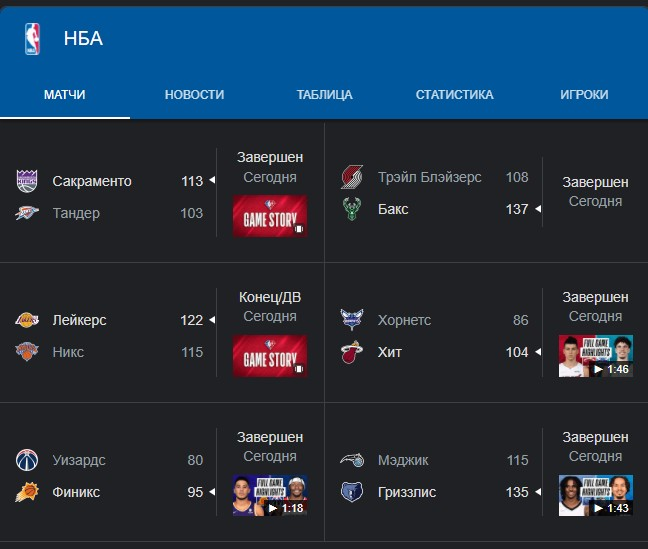

In [ ]:
from IPython.display import Image
Image(filename = "result.jpg", width=700, height=700)

In [ ]:
# Как можно наблюдать только  tab net Ошибся в  одном из  шести  матчей! все остальные  модели отлично справились с  задачей 
# Считаю поставленую Задачу  выполненой ! 6\6 

In [ ]:
# 06.02.2022

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Home','Away', 'tabnet-Home','tabnet-Away','Catboost-Home','Catboost-Away','Xgb-Home','Xgb-Away']]
# result = result.join(games_data_frame['TEAM_NAME'])

In [ ]:
result

,Home,Away,tabnet-Home,tabnet-Away,Catboost-Home,Catboost-Away,Xgb-Home,Xgb-Away
0,Chicago Bulls,Philadelphia 76ers,0.726004,0.273996,0.638245,0.361755,0.664764,0.335236
1,Minnesota Timberwolves,Detroit Pistons,0.738825,0.261175,0.879519,0.120481,0.843261,0.156739
2,Denver Nuggets,Brooklyn Nets,0.592563,0.407437,0.558834,0.441166,0.564811,0.435189
3,Cleveland Cavaliers,Indiana Pacers,0.880340,0.119660,0.824329,0.175671,0.824642,0.175358
4,Orlando Magic,Boston Celtics,0.305437,0.694563,0.207480,0.792520,0.283334,0.716666
5,Dallas Mavericks,Atlanta Hawks,0.693226,0.306775,0.658607,0.341393,0.713551,0.286449
6,Houston Rockets,New Orleans Pelicans,0.324021,0.675979,0.419378,0.580622,0.409731,0.590269
7,LA Clippers,Milwaukee Bucks,0.497042,0.502958,0.406699,0.593301,0.433997,0.566003


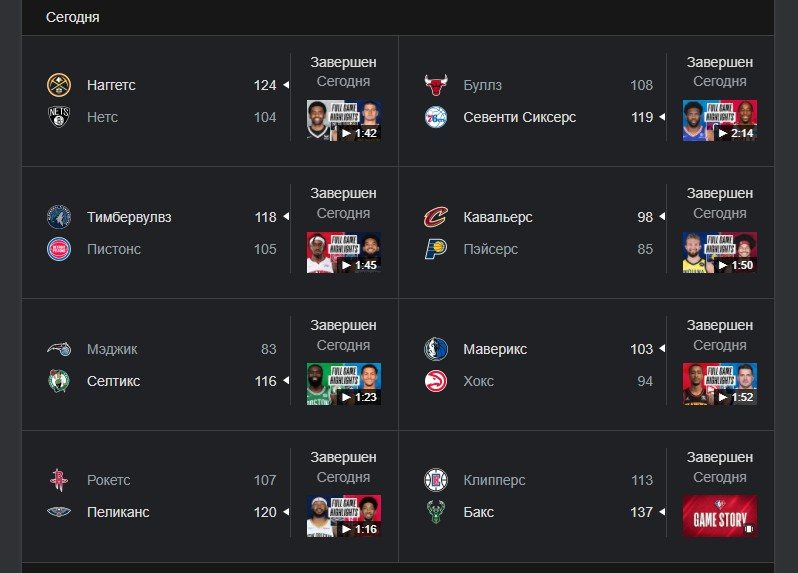

In [ ]:
from IPython.display import Image
Image(filename = "result2.jpg", width=700, height=700)

In [ ]:
def pred(x,y):
    if data.iloc[0] :
        data['winer'] = 1
    elif y.iloc > x.iloc:
        data['winer'] = 

In [ ]:
# 07.02.2022

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Home','Away', 'tabnet-Home','tabnet-Away','Catboost-Home','Catboost-Away','Xgb-Home','Xgb-Away']]
# result = result.join(games_data_frame['TEAM_NAME'])

In [ ]:
result

,Home,Away,tabnet-Home,tabnet-Away,Catboost-Home,Catboost-Away,Xgb-Home,Xgb-Away
0,Charlotte Hornets,Toronto Raptors,0.465432,0.534568,0.509407,0.490593,0.473981,0.526019
1,Washington Wizards,Miami Heat,0.344121,0.655879,0.315209,0.684791,0.408328,0.591672
2,Chicago Bulls,Phoenix Suns,0.476631,0.523369,0.443174,0.556826,0.408324,0.591676
3,Oklahoma City Thunder,Golden State Warriors,0.309205,0.690795,0.119820,0.880180,0.227566,0.772434
4,Utah Jazz,New York Knicks,0.887381,0.112619,0.808837,0.191163,0.771819,0.228181


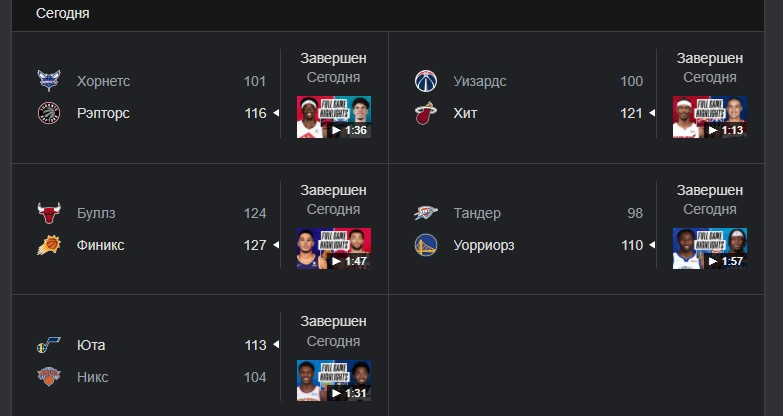

In [ ]:
from IPython.display import Image
Image(filename = "result3.jpg", width=700, height=700)

In [ ]:
 18/1 cat xgb //// 17/2 tn 

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Home','Away', 'tabnet-Home','tabnet-Away','Catboost-Home','Catboost-Away','Xgb-Home','Xgb-Away']]
# result = result.join(games_data_frame['TEAM_NAME'])

In [ ]:
result[(result[list(result.dtypes.loc[result.dtypes != 'object'].index)] > 0.7).any(axis=1)]

,Home,Away,tabnet-Home,tabnet-Away,Catboost-Home,Catboost-Away,Xgb-Home,Xgb-Away
1,Atlanta Hawks,Indiana Pacers,0.882560,0.117440,0.749554,0.250446,0.743255,0.256745
3,Memphis Grizzlies,LA Clippers,0.834432,0.165568,0.807677,0.192323,0.764234,0.235766
4,New Orleans Pelicans,Houston Rockets,0.564891,0.435109,0.711262,0.288738,0.728668,0.271332
5,Dallas Mavericks,Detroit Pistons,0.937812,0.062188,0.898999,0.101001,0.868822,0.131178
6,Denver Nuggets,New York Knicks,0.865300,0.134700,0.741509,0.258491,0.709395,0.290605


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result[(result[features] > 0.7).any(axis=1)]

,Home,Away,tabnet-Home,tabnet-Away,Catboost-Home,Catboost-Away,Xgb-Home,Xgb-Away
1,Atlanta Hawks,Indiana Pacers,0.882560,0.117440,0.749554,0.250446,0.743255,0.256745
3,Memphis Grizzlies,LA Clippers,0.834432,0.165568,0.807677,0.192323,0.764234,0.235766
4,New Orleans Pelicans,Houston Rockets,0.564891,0.435109,0.711262,0.288738,0.728668,0.271332
5,Dallas Mavericks,Detroit Pistons,0.937812,0.062188,0.898999,0.101001,0.868822,0.131178
6,Denver Nuggets,New York Knicks,0.865300,0.134700,0.741509,0.258491,0.709395,0.290605


In [ ]:
result

,Home,Away,tabnet-Home,tabnet-Away,Catboost-Home,Catboost-Away,Xgb-Home,Xgb-Away
0,Philadelphia 76ers,Phoenix Suns,0.455994,0.544006,0.393666,0.606334,0.364754,0.635246
1,Atlanta Hawks,Indiana Pacers,0.882560,0.117440,0.749554,0.250446,0.743255,0.256745
2,Brooklyn Nets,Boston Celtics,0.470906,0.529094,0.576450,0.423550,0.596034,0.403966
3,Memphis Grizzlies,LA Clippers,0.834432,0.165568,0.807677,0.192323,0.764234,0.235766
4,New Orleans Pelicans,Houston Rockets,0.564891,0.435109,0.711262,0.288738,0.728668,0.271332
5,Dallas Mavericks,Detroit Pistons,0.937812,0.062188,0.898999,0.101001,0.868822,0.131178
6,Denver Nuggets,New York Knicks,0.865300,0.134700,0.741509,0.258491,0.709395,0.290605
7,Los Angeles Lakers,Milwaukee Bucks,0.365185,0.634815,0.385765,0.614235,0.413991,0.586009
8,Portland Trail Blazers,Orlando Magic,0.655854,0.344146,0.681382,0.318618,0.666013,0.333987
9,Sacramento Kings,Minnesota Timberwolves,0.479258,0.520742,0.336058,0.663942,0.360412,0.639588


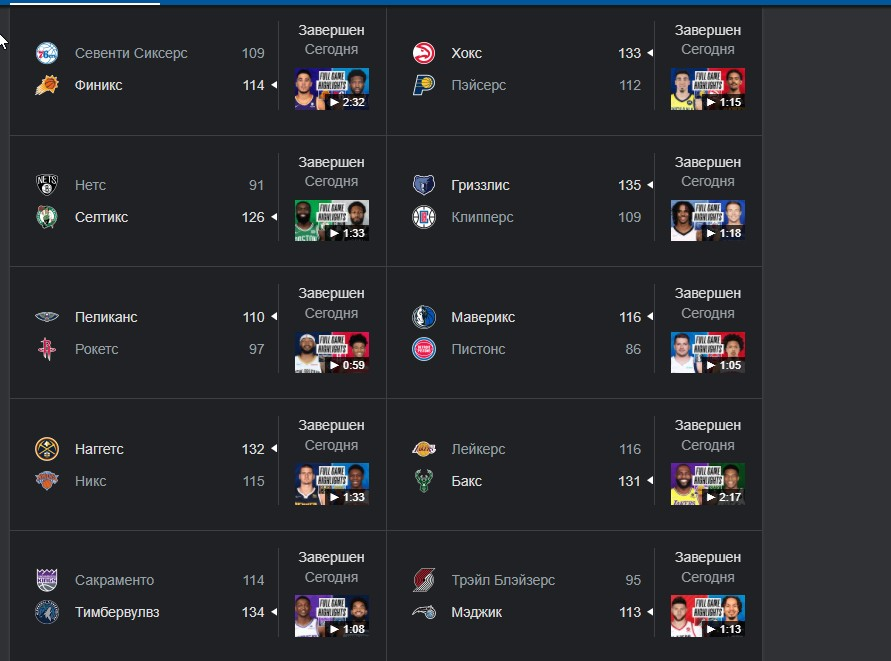

In [ ]:
from IPython.display import Image
Image(filename = "result4.jpg", width=700, height=700)

In [ ]:
tbnet + + + + + + + + - +
cb xgb  + + - + + + + + - +

In [ ]:
tbnet 26/3   cb xgb 26/3 

In [ ]:
df2 = pd.DataFrame(['team1', 'team2', 'team3', 'team4'])
df2.columns=['name']
df2

def who_win(team1, team2):
    return df2[df2.name==team1].index[0] < df2[df2.name==team2].index[0]

for x in df2.name:
    df2[x+'win'] = pd.Series(map(who_win, [x]*len(df2.name), df2.name))

df2

,name,team1win,team2win,team3win,team4win
0,team1,False,False,False,False
1,team2,True,False,False,False
2,team3,True,True,False,False
3,team4,True,True,True,False


In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home
0,San Antonio Spurs,Cleveland Cavaliers,0.142910,0.857090,0.202999,0.797001,0.181037,0.818963
1,Chicago Bulls,Charlotte Hornets,0.566621,0.433379,0.558739,0.441261,0.558372,0.441628
2,Toronto Raptors,Oklahoma City Thunder,0.792466,0.207534,0.770828,0.229172,0.665329,0.334671
3,Golden State Warriors,Utah Jazz,0.716082,0.283918,0.490742,0.509258,0.498965,0.501035
4,Los Angeles Lakers,Portland Trail Blazers,0.601639,0.398361,0.560460,0.439540,0.567585,0.432415
5,Minnesota Timberwolves,Sacramento Kings,0.520742,0.479258,0.663028,0.336972,0.639588,0.360412


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result[(result[features] > 0.7).any(axis=1)]

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home
0,San Antonio Spurs,Cleveland Cavaliers,0.142910,0.857090,0.202999,0.797001,0.181037,0.818963
2,Toronto Raptors,Oklahoma City Thunder,0.792466,0.207534,0.770828,0.229172,0.665329,0.334671
3,Golden State Warriors,Utah Jazz,0.716082,0.283918,0.490742,0.509258,0.498965,0.501035


In [ ]:
features

['tabnet-Away',
 'tabnet-Home',
 'Catboost-Away',
 'Catboost-Home',
 'Xgb-Away',
 'Xgb-Home']

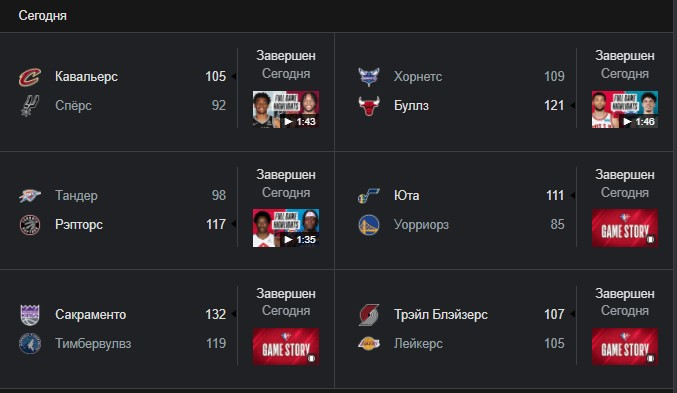

In [ ]:
from IPython.display import Image
Image(filename = "result5.jpg", width=700, height=700)

In [ ]:

28/4 28/4





In [ ]:
test279['Home-Team-Win'].value_counts()

1    153
0    126
Name: Home-Team-Win, dtype: int64

In [ ]:
predsrandom.value_counts()

1.0    153
0.0    126
Name: some_column, dtype: int64

In [ ]:
# test  all 279 next match
test279 = dd[18000:18279]
X279 = test279.drop(['Home-Team-Win'],axis=1)
y279 =  test279['Home-Team-Win']


In [ ]:
X279.loc[X279.index.isin(X279.sample(int(len(X279)*0.55)).index), 'some_column'] = 1

In [ ]:
X279['some_column'] = X279['some_column'].fillna(0)

In [ ]:
predsrandom = X279['some_column']


In [ ]:
predsrandom


18000    0.0
18001    0.0
18002    0.0
18003    1.0
18004    0.0
        ... 
18274    1.0
18275    0.0
18276    0.0
18277    0.0
18278    1.0
Name: some_column, Length: 279, dtype: float64

In [ ]:
# # test  all 279 next match
# test279 = dd[18000:18279]
# X279 = test279.drop(['Home-Team-Win'],axis=1)
# y279 =  test279['Home-Team-Win']

# X279['randpred1'] = np.random.choice([0,1], X279.shape[0])
# X279['randpred2'] = np.random.choice([0,1], X279.shape[0])
# X279['randpred3'] = np.random.choice([0,1], X279.shape[0])
# X279['randpredmean']=X279[['randpred1','randpred2','randpred3']].mean(axis=1)
# def transform(x):
#     if  x['randpredmean'] > 0.5:
#         x['randpredmean'] = 1
#     elif x['randpredmean'] < 0.5:
#         x['randpredmean'] = 0
#     return x
# X279 = X279.apply(transform, axis=1)
# X279['randpredmean'].value_counts()
# accuracy = accuracy_score(y279,X279['randpredmean'])
# accuracy

1.0    146
0.0    133
Name: randpredmean, dtype: int64

0.5448028673835126

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home
0,Memphis Grizzlies,Detroit Pistons,0.761289,0.238711,0.871794,0.128206,0.795273,0.204727
1,Brooklyn Nets,Washington Wizards,0.429234,0.570766,0.536442,0.463558,0.470141,0.529859
2,Miami Heat,New Orleans Pelicans,0.572750,0.427250,0.707935,0.292065,0.614411,0.385589
3,Toronto Raptors,Houston Rockets,0.454769,0.545231,0.770651,0.229349,0.713009,0.286991
4,LA Clippers,Dallas Mavericks,0.241729,0.758271,0.282372,0.717628,0.273817,0.726183
5,Milwaukee Bucks,Phoenix Suns,0.349738,0.650262,0.230119,0.769881,0.235206,0.764794
6,New York Knicks,Golden State Warriors,0.052585,0.947415,0.161684,0.838316,0.195143,0.804857


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result[(result[features] > 0.7).any(axis=1)]

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home
0,Memphis Grizzlies,Detroit Pistons,0.761289,0.238711,0.871794,0.128206,0.795273,0.204727
2,Miami Heat,New Orleans Pelicans,0.572750,0.427250,0.707935,0.292065,0.614411,0.385589
3,Toronto Raptors,Houston Rockets,0.454769,0.545231,0.770651,0.229349,0.713009,0.286991
4,LA Clippers,Dallas Mavericks,0.241729,0.758271,0.282372,0.717628,0.273817,0.726183
5,Milwaukee Bucks,Phoenix Suns,0.349738,0.650262,0.230119,0.769881,0.235206,0.764794
6,New York Knicks,Golden State Warriors,0.052585,0.947415,0.161684,0.838316,0.195143,0.804857


In [ ]:
result['mean-Away']=result[['tabnet-Away','Catboost-Away','Xgb-Away']].mean(axis=1)
result['mean-Home']=result[['tabnet-Home','Catboost-Home','Xgb-Home']].mean(axis=1)

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Memphis Grizzlies,Detroit Pistons,0.761289,0.238711,0.871794,0.128206,0.795273,0.204727,0.809452,0.190548
1,Brooklyn Nets,Washington Wizards,0.429234,0.570766,0.536442,0.463558,0.470141,0.529859,0.478606,0.521394
2,Miami Heat,New Orleans Pelicans,0.572750,0.427250,0.707935,0.292065,0.614411,0.385589,0.631699,0.368301
3,Toronto Raptors,Houston Rockets,0.454769,0.545231,0.770651,0.229349,0.713009,0.286991,0.646143,0.353857
4,LA Clippers,Dallas Mavericks,0.241729,0.758271,0.282372,0.717628,0.273817,0.726183,0.265973,0.734028
5,Milwaukee Bucks,Phoenix Suns,0.349738,0.650262,0.230119,0.769881,0.235206,0.764794,0.271688,0.728312
6,New York Knicks,Golden State Warriors,0.052585,0.947415,0.161684,0.838316,0.195143,0.804857,0.136471,0.863529


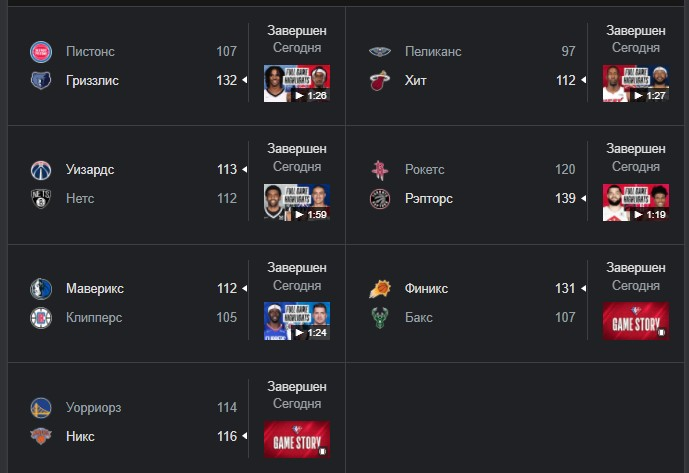

In [ ]:
from IPython.display import Image
Image(filename = "result6.jpg", width=700, height=700)

In [ ]:
33/5 

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home
0,Charlotte Hornets,Detroit Pistons,0.752187,0.247813,0.747376,0.252624,0.718915,0.281085
1,Cleveland Cavaliers,Indiana Pacers,0.565628,0.434372,0.735145,0.264855,0.649108,0.350892
2,Oklahoma City Thunder,Philadelphia 76ers,0.138202,0.861798,0.150039,0.849961,0.145477,0.854523
3,San Antonio Spurs,Atlanta Hawks,0.062177,0.937823,0.304304,0.695696,0.315319,0.684681
4,Denver Nuggets,Boston Celtics,0.335664,0.664336,0.428023,0.571977,0.412951,0.587049
5,Minnesota Timberwolves,Chicago Bulls,0.375627,0.624373,0.274780,0.725220,0.312511,0.687489
6,Orlando Magic,Utah Jazz,0.088998,0.911002,0.084281,0.915719,0.119864,0.880136


In [ ]:
result['mean-Away']=result[['tabnet-Away','Catboost-Away','Xgb-Away']].mean(axis=1)
result['mean-Home']=result[['tabnet-Home','Catboost-Home','Xgb-Home']].mean(axis=1)

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Charlotte Hornets,Detroit Pistons,0.752187,0.247813,0.747376,0.252624,0.718915,0.281085,0.739493,0.260507
1,Cleveland Cavaliers,Indiana Pacers,0.565628,0.434372,0.735145,0.264855,0.649108,0.350892,0.649960,0.350040
2,Oklahoma City Thunder,Philadelphia 76ers,0.138202,0.861798,0.150039,0.849961,0.145477,0.854523,0.144573,0.855427
3,San Antonio Spurs,Atlanta Hawks,0.062177,0.937823,0.304304,0.695696,0.315319,0.684681,0.227267,0.772733
4,Denver Nuggets,Boston Celtics,0.335664,0.664336,0.428023,0.571977,0.412951,0.587049,0.392213,0.607787
5,Minnesota Timberwolves,Chicago Bulls,0.375627,0.624373,0.274780,0.725220,0.312511,0.687489,0.320972,0.679028
6,Orlando Magic,Utah Jazz,0.088998,0.911002,0.084281,0.915719,0.119864,0.880136,0.097715,0.902285


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result[(result[features] > 0.65).any(axis=1)] 

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Charlotte Hornets,Detroit Pistons,0.752187,0.247813,0.747376,0.252624,0.718915,0.281085,0.739493,0.260507
1,Cleveland Cavaliers,Indiana Pacers,0.565628,0.434372,0.735145,0.264855,0.649108,0.350892,0.649960,0.350040
2,Oklahoma City Thunder,Philadelphia 76ers,0.138202,0.861798,0.150039,0.849961,0.145477,0.854523,0.144573,0.855427
3,San Antonio Spurs,Atlanta Hawks,0.062177,0.937823,0.304304,0.695696,0.315319,0.684681,0.227267,0.772733
4,Denver Nuggets,Boston Celtics,0.335664,0.664336,0.428023,0.571977,0.412951,0.587049,0.392213,0.607787
5,Minnesota Timberwolves,Chicago Bulls,0.375627,0.624373,0.274780,0.725220,0.312511,0.687489,0.320972,0.679028
6,Orlando Magic,Utah Jazz,0.088998,0.911002,0.084281,0.915719,0.119864,0.880136,0.097715,0.902285


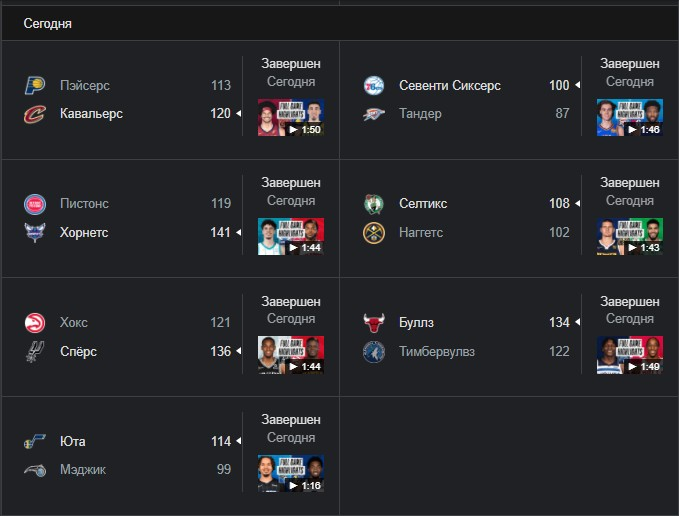

In [ ]:
from IPython.display import Image
Image(filename = "result7.jpg", width=700, height=700)

In [ ]:
6/1

In [ ]:
39/6

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])
result['mean-Away']=result[['tabnet-Away','Catboost-Away','Xgb-Away']].mean(axis=1)
result['mean-Home']=result[['tabnet-Home','Catboost-Home','Xgb-Home']].mean(axis=1)


In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,New York Knicks,Portland Trail Blazers,0.628520,0.371480,0.522059,0.477941,0.543033,0.456967,0.564538,0.435462
1,Memphis Grizzlies,Charlotte Hornets,0.817712,0.182288,0.600480,0.399520,0.631796,0.368204,0.683329,0.316671
2,Sacramento Kings,Washington Wizards,0.351421,0.648579,0.324799,0.675201,0.332141,0.667859,0.336120,0.663880
3,San Antonio Spurs,New Orleans Pelicans,0.382029,0.617971,0.447724,0.552276,0.426574,0.573426,0.418775,0.581225
4,Cleveland Cavaliers,Philadelphia 76ers,0.506724,0.493276,0.426772,0.573228,0.414251,0.585749,0.449249,0.550751
5,Denver Nuggets,Toronto Raptors,0.347625,0.652375,0.414384,0.585616,0.350703,0.649297,0.370904,0.629096
6,Brooklyn Nets,Miami Heat,0.151783,0.848217,0.253676,0.746324,0.292134,0.707866,0.232531,0.767469
7,Oklahoma City Thunder,Chicago Bulls,0.164837,0.835163,0.121213,0.878787,0.138542,0.861458,0.141531,0.858469
8,LA Clippers,Dallas Mavericks,0.244868,0.755132,0.272382,0.727618,0.255032,0.744968,0.257428,0.742572
9,Los Angeles Lakers,Golden State Warriors,0.117535,0.882465,0.179675,0.820325,0.198868,0.801132,0.165359,0.834641


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result[(result[features] > 0.7).any(axis=1)]

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
1,Memphis Grizzlies,Charlotte Hornets,0.817712,0.182288,0.600480,0.399520,0.631796,0.368204,0.683329,0.316671
6,Brooklyn Nets,Miami Heat,0.151783,0.848217,0.253676,0.746324,0.292134,0.707866,0.232531,0.767469
7,Oklahoma City Thunder,Chicago Bulls,0.164837,0.835163,0.121213,0.878787,0.138542,0.861458,0.141531,0.858469
8,LA Clippers,Dallas Mavericks,0.244868,0.755132,0.272382,0.727618,0.255032,0.744968,0.257428,0.742572
9,Los Angeles Lakers,Golden State Warriors,0.117535,0.882465,0.179675,0.820325,0.198868,0.801132,0.165359,0.834641
10,Orlando Magic,Phoenix Suns,0.031312,0.968688,0.043378,0.956622,0.058715,0.941285,0.044468,0.955532


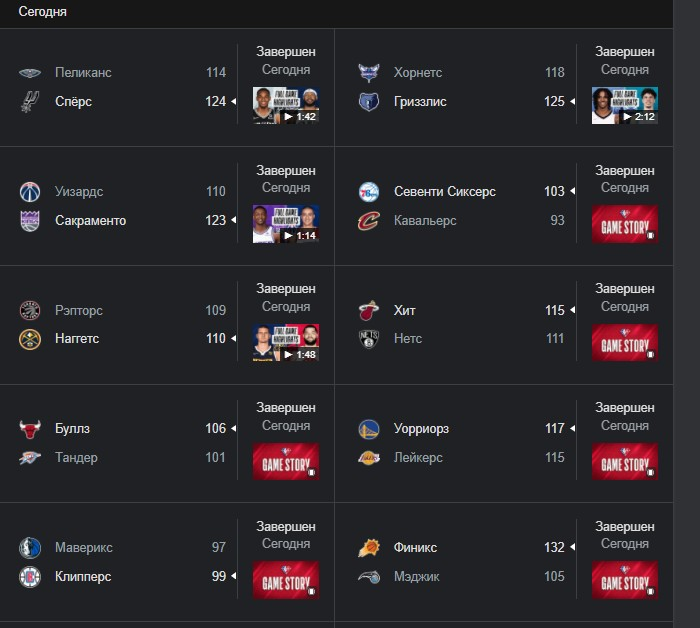

In [ ]:
from IPython.display import Image
Image(filename = "result8.jpg", width=700, height=700)

In [ ]:
5/1  44/7

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])
result['mean-Away']=result[['tabnet-Away','Catboost-Away','Xgb-Away']].mean(axis=1)
result['mean-Home']=result[['tabnet-Home','Catboost-Home','Xgb-Home']].mean(axis=1)


In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Atlanta Hawks,Boston Celtics,0.361234,0.638766,0.336500,0.663500,0.277453,0.722547,0.325063,0.674938
1,Minnesota Timberwolves,Indiana Pacers,0.566149,0.433851,0.646178,0.353822,0.605694,0.394306,0.606007,0.393993


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result[(result[features] > 0.7).any(axis=1)]

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Atlanta Hawks,Boston Celtics,0.361234,0.638766,0.3365,0.6635,0.277453,0.722547,0.325063,0.674938


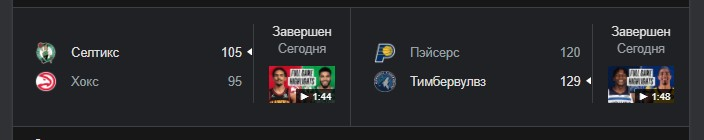

In [ ]:
from IPython.display import Image
Image(filename = "result9.jpg", width=700, height=700)

In [ ]:
46/7

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])
result['mean-Away']=result[['tabnet-Away','Catboost-Away','Xgb-Away']].mean(axis=1)
result['mean-Home']=result[['tabnet-Home','Catboost-Home','Xgb-Home']].mean(axis=1)

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Detroit Pistons,Washington Wizards,0.196628,0.803372,0.189290,0.810710,0.229272,0.770728,0.205064,0.794936
1,Sacramento Kings,Brooklyn Nets,0.227158,0.772842,0.245602,0.754398,0.285975,0.714025,0.252912,0.747088
2,Oklahoma City Thunder,New York Knicks,0.230081,0.769919,0.291213,0.708787,0.273127,0.726873,0.264807,0.735193
3,San Antonio Spurs,Chicago Bulls,0.228849,0.771151,0.197402,0.802598,0.200860,0.799140,0.209037,0.790963
4,Portland Trail Blazers,Milwaukee Bucks,0.142861,0.857139,0.167824,0.832176,0.196299,0.803701,0.168995,0.831005
5,Toronto Raptors,New Orleans Pelicans,0.523405,0.476595,0.618586,0.381414,0.599675,0.400325,0.580555,0.419445
6,Orlando Magic,Denver Nuggets,0.141684,0.858316,0.128656,0.871344,0.139848,0.860152,0.136729,0.863271
7,Houston Rockets,Utah Jazz,0.088678,0.911322,0.099895,0.900105,0.138542,0.861458,0.109038,0.890962
8,Golden State Warriors,LA Clippers,0.832324,0.167676,0.697531,0.302469,0.642427,0.357573,0.724094,0.275906


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result[(result[features] > 0.7).any(axis=1)]


,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Detroit Pistons,Washington Wizards,0.196628,0.803372,0.189290,0.810710,0.229272,0.770728,0.205064,0.794936
1,Sacramento Kings,Brooklyn Nets,0.227158,0.772842,0.245602,0.754398,0.285975,0.714025,0.252912,0.747088
2,Oklahoma City Thunder,New York Knicks,0.230081,0.769919,0.291213,0.708787,0.273127,0.726873,0.264807,0.735193
3,San Antonio Spurs,Chicago Bulls,0.228849,0.771151,0.197402,0.802598,0.200860,0.799140,0.209037,0.790963
4,Portland Trail Blazers,Milwaukee Bucks,0.142861,0.857139,0.167824,0.832176,0.196299,0.803701,0.168995,0.831005
6,Orlando Magic,Denver Nuggets,0.141684,0.858316,0.128656,0.871344,0.139848,0.860152,0.136729,0.863271
7,Houston Rockets,Utah Jazz,0.088678,0.911322,0.099895,0.900105,0.138542,0.861458,0.109038,0.890962
8,Golden State Warriors,LA Clippers,0.832324,0.167676,0.697531,0.302469,0.642427,0.357573,0.724094,0.275906


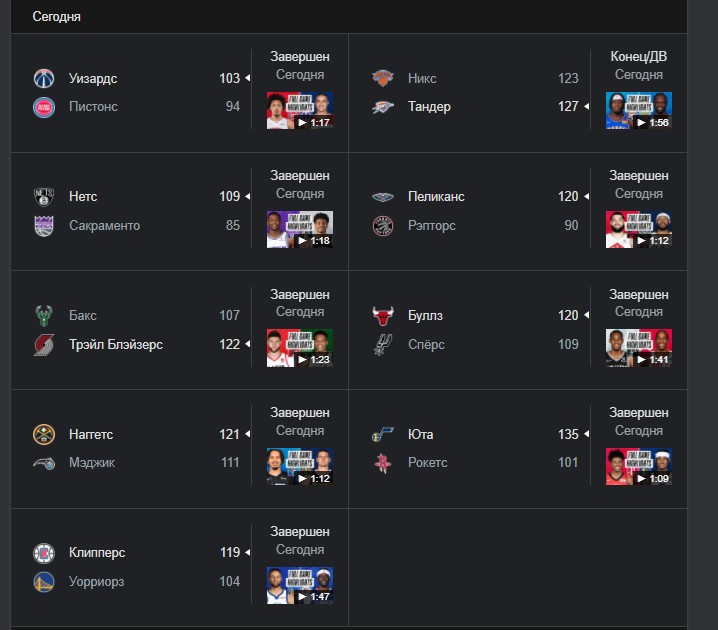

In [ ]:
from IPython.display import Image
Image(filename = "result10.jpg", width=700, height=700)

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])
result['mean-Away']=result[['tabnet-Away','Catboost-Away','Xgb-Away']].mean(axis=1)
result['mean-Home']=result[['tabnet-Home','Catboost-Home','Xgb-Home']].mean(axis=1)

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Detroit Pistons,Washington Wizards,0.185132,0.814868,0.216528,0.783472,0.207808,0.792192,0.203156,0.796844
1,Sacramento Kings,Brooklyn Nets,0.236200,0.763800,0.245553,0.754447,0.246859,0.753141,0.242871,0.757129
2,Oklahoma City Thunder,New York Knicks,0.277577,0.722423,0.289739,0.710261,0.300300,0.699700,0.289205,0.710795
3,San Antonio Spurs,Chicago Bulls,0.189578,0.810422,0.221477,0.778523,0.195751,0.804249,0.202269,0.797731
4,Portland Trail Blazers,Milwaukee Bucks,0.217985,0.782015,0.223408,0.776592,0.223488,0.776512,0.221627,0.778373
5,Toronto Raptors,New Orleans Pelicans,0.584227,0.415773,0.542759,0.457241,0.576420,0.423580,0.567802,0.432198
6,Orlando Magic,Denver Nuggets,0.118593,0.881407,0.141514,0.858486,0.139549,0.860451,0.133219,0.866781
7,Houston Rockets,Utah Jazz,0.137627,0.862373,0.131442,0.868558,0.150436,0.849564,0.139835,0.860165
8,Golden State Warriors,LA Clippers,0.695278,0.304722,0.660502,0.339498,0.624270,0.375730,0.660017,0.339983


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result[(result[features] > 0.7).any(axis=1)]

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Detroit Pistons,Washington Wizards,0.185132,0.814868,0.216528,0.783472,0.207808,0.792192,0.203156,0.796844
1,Sacramento Kings,Brooklyn Nets,0.236200,0.763800,0.245553,0.754447,0.246859,0.753141,0.242871,0.757129
2,Oklahoma City Thunder,New York Knicks,0.277577,0.722423,0.289739,0.710261,0.300300,0.699700,0.289205,0.710795
3,San Antonio Spurs,Chicago Bulls,0.189578,0.810422,0.221477,0.778523,0.195751,0.804249,0.202269,0.797731
4,Portland Trail Blazers,Milwaukee Bucks,0.217985,0.782015,0.223408,0.776592,0.223488,0.776512,0.221627,0.778373
6,Orlando Magic,Denver Nuggets,0.118593,0.881407,0.141514,0.858486,0.139549,0.860451,0.133219,0.866781
7,Houston Rockets,Utah Jazz,0.137627,0.862373,0.131442,0.868558,0.150436,0.849564,0.139835,0.860165


In [ ]:
50/9

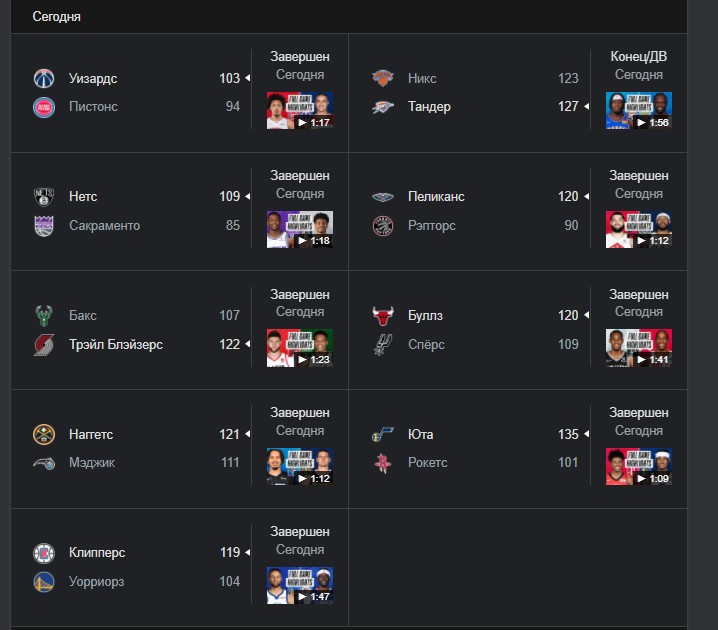

In [ ]:
from IPython.display import Image
Image(filename = "result10.jpg", width=700, height=700)

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])
result['mean-Away']=result[['tabnet-Away','Catboost-Away','Xgb-Away']].mean(axis=1)
result['mean-Home']=result[['tabnet-Home','Catboost-Home','Xgb-Home']].mean(axis=1)

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Cleveland Cavaliers,Atlanta Hawks,0.550364,0.449636,0.517833,0.482167,0.565169,0.434831,0.544455,0.455545
1,Dallas Mavericks,Miami Heat,0.350445,0.649555,0.334790,0.665210,0.346768,0.653232,0.344001,0.655999
2,Boston Celtics,Philadelphia 76ers,0.366411,0.633588,0.404098,0.595902,0.346307,0.653693,0.372272,0.627728
3,Indiana Pacers,Milwaukee Bucks,0.170318,0.829682,0.185929,0.814071,0.163667,0.836333,0.173305,0.826695
4,Charlotte Hornets,Minnesota Timberwolves,0.383436,0.616564,0.342424,0.657576,0.344642,0.655358,0.356834,0.643166
5,Memphis Grizzlies,New Orleans Pelicans,0.722567,0.277433,0.694071,0.305929,0.708176,0.291824,0.708271,0.291729
6,LA Clippers,Phoenix Suns,0.153683,0.846317,0.116670,0.883330,0.096650,0.903350,0.122334,0.877666


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result[(result[features] > 0.7).any(axis=1)]

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
3,Indiana Pacers,Milwaukee Bucks,0.170318,0.829682,0.185929,0.814071,0.163667,0.836333,0.173305,0.826695
5,Memphis Grizzlies,New Orleans Pelicans,0.722567,0.277433,0.694071,0.305929,0.708176,0.291824,0.708271,0.291729
6,LA Clippers,Phoenix Suns,0.153683,0.846317,0.116670,0.883330,0.096650,0.903350,0.122334,0.877666


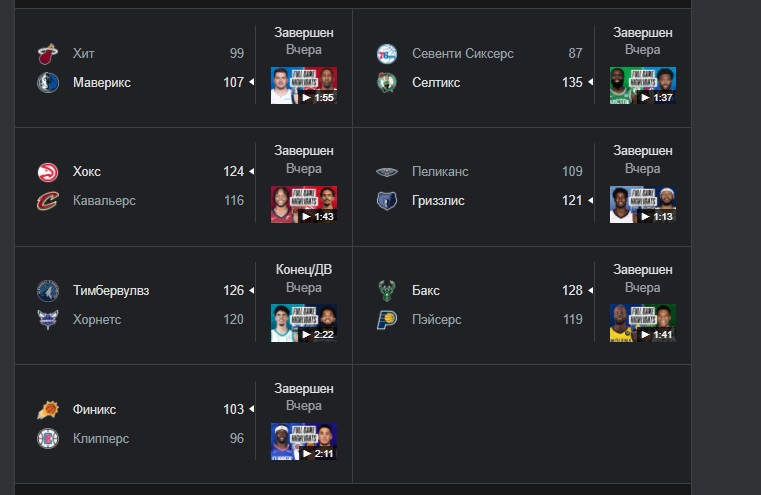

In [ ]:
from IPython.display import Image
Image(filename = "result11.jpg", width=700, height=700)

In [ ]:
53/9

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
result = pd.concat([result, games_data_frame['TEAM_NAME']], axis=1)
result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# result = result.join(games_data_frame['TEAM_NAME'])
result['mean-Away']=result[['tabnet-Away','Catboost-Away','Xgb-Away']].mean(axis=1)
result['mean-Home']=result[['tabnet-Home','Catboost-Home','Xgb-Home']].mean(axis=1)

In [ ]:
result

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Atlanta Hawks,Orlando Magic,0.731730,0.268270,0.750293,0.249707,0.752611,0.247389,0.744878,0.255122
1,Detroit Pistons,Boston Celtics,0.127691,0.872309,0.120365,0.879635,0.127539,0.872461,0.125198,0.874802
2,Washington Wizards,Indiana Pacers,0.561831,0.438169,0.514774,0.485226,0.578851,0.421149,0.551819,0.448181
3,Brooklyn Nets,New York Knicks,0.504089,0.495911,0.519399,0.480601,0.474688,0.525312,0.499392,0.500608
4,Sacramento Kings,Chicago Bulls,0.155132,0.844868,0.176462,0.823538,0.184992,0.815008,0.172195,0.827805
5,Portland Trail Blazers,Memphis Grizzlies,0.188928,0.811072,0.194353,0.805647,0.189086,0.810914,0.190789,0.809211
6,Toronto Raptors,Minnesota Timberwolves,0.464529,0.535471,0.432048,0.567952,0.405528,0.594472,0.434035,0.565965
7,San Antonio Spurs,Oklahoma City Thunder,0.508634,0.491366,0.566701,0.433299,0.577852,0.422148,0.551062,0.448938
8,Houston Rockets,Phoenix Suns,0.029535,0.970465,0.052770,0.947230,0.061616,0.938384,0.047974,0.952026
9,Denver Nuggets,Golden State Warriors,0.298038,0.701962,0.269560,0.730440,0.316377,0.683623,0.294659,0.705341


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result[(result[features] > 0.7).any(axis=1)]

,Away,Home,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,Atlanta Hawks,Orlando Magic,0.731730,0.268270,0.750293,0.249707,0.752611,0.247389,0.744878,0.255122
1,Detroit Pistons,Boston Celtics,0.127691,0.872309,0.120365,0.879635,0.127539,0.872461,0.125198,0.874802
4,Sacramento Kings,Chicago Bulls,0.155132,0.844868,0.176462,0.823538,0.184992,0.815008,0.172195,0.827805
5,Portland Trail Blazers,Memphis Grizzlies,0.188928,0.811072,0.194353,0.805647,0.189086,0.810914,0.190789,0.809211
8,Houston Rockets,Phoenix Suns,0.029535,0.970465,0.052770,0.947230,0.061616,0.938384,0.047974,0.952026
9,Denver Nuggets,Golden State Warriors,0.298038,0.701962,0.269560,0.730440,0.316377,0.683623,0.294659,0.705341


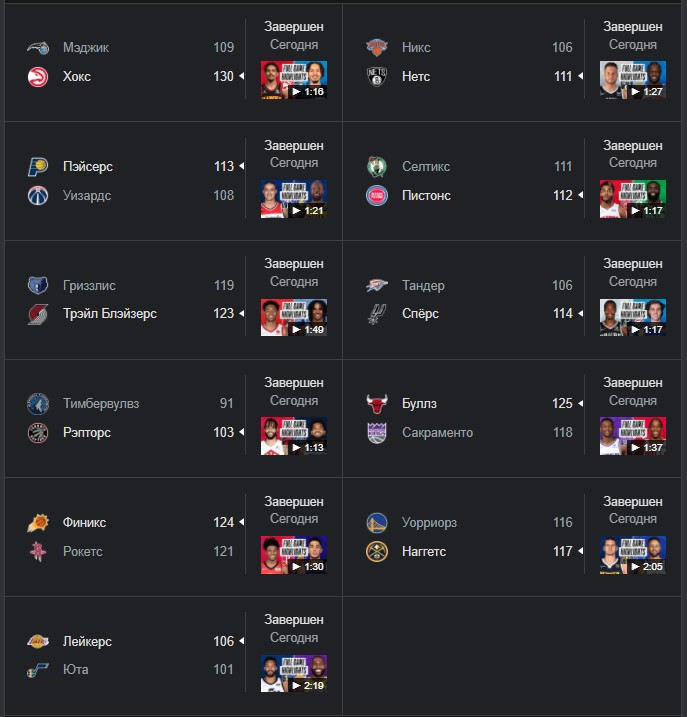

In [ ]:
from IPython.display import Image
Image(filename = "result12.jpg", width=700, height=700)

In [ ]:
list(test279.columns)


['GP',
 'W',
 'L',
 'W_PCT',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'GP_RANK',
 'W_RANK',
 'L_RANK',
 'W_PCT_RANK',
 'MIN_RANK',
 'FGM_RANK',
 'FGA_RANK',
 'FG_PCT_RANK',
 'FG3M_RANK',
 'FG3A_RANK',
 'FG3_PCT_RANK',
 'FTM_RANK',
 'FTA_RANK',
 'FT_PCT_RANK',
 'OREB_RANK',
 'DREB_RANK',
 'REB_RANK',
 'AST_RANK',
 'TOV_RANK',
 'STL_RANK',
 'BLK_RANK',
 'BLKA_RANK',
 'PF_RANK',
 'PFD_RANK',
 'PTS_RANK',
 'PLUS_MINUS_RANK',
 'GP.1',
 'W.1',
 'L.1',
 'W_PCT.1',
 'MIN.1',
 'FGM.1',
 'FGA.1',
 'FG_PCT.1',
 'FG3M.1',
 'FG3A.1',
 'FG3_PCT.1',
 'FTM.1',
 'FTA.1',
 'FT_PCT.1',
 'OREB.1',
 'DREB.1',
 'REB.1',
 'AST.1',
 'TOV.1',
 'STL.1',
 'BLK.1',
 'BLKA.1',
 'PF.1',
 'PFD.1',
 'PTS.1',
 'PLUS_MINUS.1',
 'GP_RANK.1',
 'W_RANK.1',
 'L_RANK.1',
 'W_PCT_RANK.1',
 'MIN_RANK.1',
 'FGM_RANK.1',
 'FGA_RANK.1',
 'FG_PCT_RANK.1',
 'FG3M_RANK.1',
 'FG

In [ ]:
# # Загружаем данные
# df = pd.read_csv('allseasons2007-22.csv')
# df.drop(['Score',  'Unnamed: 0', 'TEAM_NAME', 'TEAM_NAME.1', 'Date.1', 'OU-Cover', 'OU','TEAM_ID','TEAM_ID.1'],
#           axis=1, inplace=True)
# df.drop_duplicates(keep=False)
ff = pd.read_csv('allseasons2007-22.csv')

In [ ]:
ff = ff[18000:18279]

In [ ]:
# test  all 279 next match
test279 = dd[18000:18279]
X279 = test279.drop(['Home-Team-Win'],axis=1).values
y279 =  test279['Home-Team-Win'].values

In [ ]:
Tabnet = TabNetClassifier()
Tabnet.load_model('tabnet.zip')
Tabnet = Tabnet.predict_proba(X279)


Device used : cpu


In [ ]:
catboost = CatBoostClassifier()
catboost.load_model("catboost")
catboost = catboost.predict_proba(X279)


In [ ]:
xgb_ml = xgb.Booster()
xgb_ml.load_model('xgbc')
xgb_ml = xgb_ml.predict(xgb.DMatrix(np.array(X279)))
xgb_ml = xgb_ml.reshape(-1, 1)
xgb_ml1 = 1 - xgb_ml
xgb_ml = np.hstack((xgb_ml1, xgb_ml))

[14:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:854: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [ ]:
# тест 279 последних  игр
y_pred279 = cbmn.predict(X279)

metrics(summary,'cbmn279',y279,y_pred279),conf_mat(y279, y_pred279)

NameError: name 'cbmn' is not defined

In [ ]:
# обьеденим  результаты в  таблицу 
result = np.hstack((Tabnet,catboost,xgb_ml))
result = pd.DataFrame(result,columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home'])
# result = pd.concat([result, ff['TEAM_NAME']], axis=0)
# result.columns=['tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home','Home','Away']
# result = result[['Away','Home', 'tabnet-Away','tabnet-Home','Catboost-Away','Catboost-Home','Xgb-Away','Xgb-Home']]
# # result = result.join(games_data_frame['TEAM_NAME'])
result['mean-Away']=result[['tabnet-Away','Catboost-Away','Xgb-Away']].mean(axis=1)
result['mean-Home']=result[['tabnet-Home','Catboost-Home','Xgb-Home']].mean(axis=1)


In [ ]:
result

,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
0,0.353602,0.646398,0.453443,0.546557,0.458753,0.541247,0.421933,0.578067
1,0.278169,0.721831,0.317505,0.682495,0.325109,0.674891,0.306927,0.693072
2,0.557245,0.442755,0.519293,0.480707,0.540609,0.459390,0.539049,0.460951
3,0.243271,0.756729,0.273130,0.726870,0.294389,0.705611,0.270263,0.729737
4,0.488365,0.511635,0.723765,0.276235,0.637785,0.362215,0.616639,0.383361
...,...,...,...,...,...,...,...,...
274,0.427927,0.572073,0.633668,0.366332,0.602383,0.397617,0.554659,0.445341
275,0.442613,0.557387,0.495306,0.504694,0.471463,0.528537,0.469794,0.530206
276,0.137403,0.862597,0.131144,0.868856,0.161070,0.838930,0.143206,0.856794
277,0.468726,0.531273,0.570722,0.429278,0.589065,0.410935,0.542838,0.457162


In [ ]:
features = list(result.dtypes.loc[result.dtypes != 'object'].index)
result=result[(result[features] > 0.75).any(axis=1)]

In [ ]:
result

,tabnet-Away,tabnet-Home,Catboost-Away,Catboost-Home,Xgb-Away,Xgb-Home,mean-Away,mean-Home
3,0.243271,0.756729,0.273130,0.726870,0.294389,0.705611,0.270263,0.729737
5,0.023937,0.976063,0.139048,0.860952,0.147888,0.852112,0.103624,0.896376
6,0.065072,0.934928,0.162075,0.837925,0.148122,0.851878,0.125090,0.874910
8,0.004768,0.995232,0.087122,0.912878,0.096346,0.903654,0.062745,0.937255
9,0.756750,0.243250,0.868252,0.131748,0.807680,0.192320,0.810894,0.189106
...,...,...,...,...,...,...,...,...
268,0.243257,0.756743,0.481501,0.518499,0.446711,0.553289,0.390489,0.609511
271,0.672972,0.327028,0.847146,0.152854,0.770656,0.229344,0.763591,0.236409
272,0.164012,0.835988,0.244975,0.755025,0.256105,0.743895,0.221698,0.778302
273,0.178942,0.821058,0.352524,0.647476,0.323996,0.676004,0.285154,0.714846


In [ ]:
accuracy = accuracy_score(y279,X279['randpredmean'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices